# Conversational agent

- Agents
    - are a combination of LLMs and code
    - LLMs reason about what steps to take and call for actions.
- Agent loop
    - Choose a tool to use
    - Observe the output of the tool
    - Repeat until a stopping condition is met
- Stopping conditions can be:
    - LLM determined
    - Hardcoded rules
    
In this lab you will

- Build some tools
- Write your own agent loop using LCEL
- Utilize `agent_executor` which:
    - Implements the agent loop
    - Adds error handling, early stopping, tracing, etc

In [1]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

### Create tools

In [2]:
from langchain.tools import tool
import requests
from pydantic import BaseModel, Field
import datetime

# Define the input schema
class OpenMeteoInput(BaseModel):
    latitude: float = Field(..., description="Latitude of the location to fetch weather data for")
    longitude: float = Field(..., description="Longitude of the location to fetch weather data for")

@tool(args_schema=OpenMeteoInput)
def get_current_temperature(latitude: float, longitude: float) -> dict:
    """Fetch current temperature for given coordinates."""
    
    BASE_URL = "https://api.open-meteo.com/v1/forecast"
    
    # Parameters for the request
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'hourly': 'temperature_2m',
        'forecast_days': 1,
    }

    # Make the request
    response = requests.get(BASE_URL, params=params)
    
    if response.status_code == 200:
        results = response.json()
    else:
        raise Exception(f"API Request failed with status code: {response.status_code}")

    current_utc_time = datetime.datetime.utcnow()
    time_list = [datetime.datetime.fromisoformat(time_str.replace('Z', '+00:00')) for time_str in results['hourly']['time']]
    temperature_list = results['hourly']['temperature_2m']
    
    closest_time_index = min(range(len(time_list)), key=lambda i: abs(time_list[i] - current_utc_time))
    current_temperature = temperature_list[closest_time_index]
    
    return f'The current temperature is {current_temperature}°C'

In [3]:
import wikipedia

@tool
def search_wikipedia(query: str) -> str:
    """Run Wikipedia search and get page summaries."""
    page_titles = wikipedia.search(query)
    summaries = []
    for page_title in page_titles[: 3]:
        try:
            wiki_page =  wikipedia.page(title=page_title, auto_suggest=False)
            summaries.append(f"Page: {page_title}\nSummary: {wiki_page.summary}")
        except (
            self.wiki_client.exceptions.PageError,
            self.wiki_client.exceptions.DisambiguationError,
        ):
            pass
    if not summaries:
        return "No good Wikipedia Search Result was found"
    return "\n\n".join(summaries)

In [4]:
tools = [get_current_temperature, search_wikipedia]

### Model, Chain and tools

In [5]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

In [6]:
functions = [format_tool_to_openai_function(f) for f in tools]
model = ChatOpenAI(temperature=0).bind(functions=functions)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
])
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

In [7]:
result = chain.invoke({"input": "what is the weather is sf?"})

In [8]:
result.tool # LLM will return the tool that recommand to use

'get_current_temperature'

In [9]:
result.tool_input

{'latitude': 37.7749, 'longitude': -122.4194}

### use MessagesPlaceholder to store a list of messages 

In [15]:
from langchain.prompts import MessagesPlaceholder
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
    
     # The action and observation pair
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

In [16]:
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

In [17]:
result1 = chain.invoke({
    "input": "what is the weather is sf?",
    "agent_scratchpad": [] # empty list since we haven't taken any action yet
})

In [29]:
result1

AgentActionMessageLog(tool='get_current_temperature', tool_input={'latitude': 37.7749, 'longitude': -122.4194}, log="\nInvoking: `get_current_temperature` with `{'latitude': 37.7749, 'longitude': -122.4194}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_current_temperature', 'arguments': '{"latitude":37.7749,"longitude":-122.4194}'}})])

In [18]:
result1.tool

'get_current_temperature'

In [21]:
# Try to call the function that LLM think we should call according to the input
observation = get_current_temperature(result1.tool_input)
observation

'The current temperature is 12.2°C'

In [22]:
type(result1)

langchain.schema.agent.AgentActionMessageLog

### Convert AgentActionMessageLog and observation to pass to `agent_scratchpad`

In [24]:
from langchain.agents.format_scratchpad import format_to_openai_functions

result1.message_log # A list of message how we arrive to the current state

[AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_current_temperature', 'arguments': '{"latitude":37.7749,"longitude":-122.4194}'}})]

In [25]:
format_to_openai_functions([(result1, observation), ])

# It will return the [AIMessage(), and FunctionMessage()]

[AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_current_temperature', 'arguments': '{"latitude":37.7749,"longitude":-122.4194}'}}),
 FunctionMessage(content='The current temperature is 12.2°C', name='get_current_temperature')]

In [27]:
result2 = chain.invoke({
    "input": "what is the weather is sf?", 
    "agent_scratchpad": format_to_openai_functions([(result1, observation)])
})

In [28]:
result2 # We will get AgentFinish() this time instead of AgentActionMessageLog()

AgentFinish(return_values={'output': 'The current temperature in San Francisco is 12.2°C.'}, log='The current temperature in San Francisco is 12.2°C.')

### Bundle all up

In [30]:
from langchain.schema.agent import AgentFinish
def run_agent(user_input):
    intermediate_steps = []
    while True:
        
        result = chain.invoke({
            "input": user_input, 
            "agent_scratchpad": format_to_openai_functions(intermediate_steps)
        })
        
        if isinstance(result, AgentFinish):
            return result
        
        # Keep getting the actions
        tool = {
            "search_wikipedia": search_wikipedia, 
            "get_current_temperature": get_current_temperature,
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation)) # Append the actions to the list

### Put format_to_openai_functions() into the chain itself to make it more protable

In [31]:
from langchain.schema.runnable import RunnablePassthrough

# RunnablePassthrough takes intial input and passe it through
# assgin() create a new argument(agent_scratchpad) with the output of format_to_openai_functions
agent_chain = RunnablePassthrough.assign(
    agent_scratchpad= lambda x: format_to_openai_functions(x["intermediate_steps"])
) | chain

In [32]:
def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = agent_chain.invoke({
            "input": user_input, 
            
            # the preprocessing is inside the chain now!
            "intermediate_steps": intermediate_steps 
        })
        
        if isinstance(result, AgentFinish):
            return result
        
        tool = {
            "search_wikipedia": search_wikipedia, 
            "get_current_temperature": get_current_temperature,
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))

In [33]:
run_agent("what is the weather is sf?")

AgentFinish(return_values={'output': 'The current temperature in San Francisco is 12.3°C.'}, log='The current temperature in San Francisco is 12.3°C.')

In [34]:
run_agent("what is langchain?")

AgentFinish(return_values={'output': 'LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). It is a language model integration framework that can be used for document analysis and summarization, chatbots, and code analysis.'}, log='LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). It is a language model integration framework that can be used for document analysis and summarization, chatbots, and code analysis.')

In [35]:
run_agent("hi!")

AgentFinish(return_values={'output': 'Well, hello there! How can I sass... I mean, assist you today?'}, log='Well, hello there! How can I sass... I mean, assist you today?')

##  This part is legacy, use LangGraph agent instead

What AgentExecutor class does, is to do similar loop that we did above with better tools, error handlings, logs around the agentic flow.

https://python.langchain.com/v0.2/docs/how_to/agent_executor/

In [36]:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True)

In [37]:
agent_executor.invoke({"input": "what is langchain?"})



> Entering new AgentExecutor chain...

Invoking: `search_wikipedia` with `{'query': 'Langchain'}`


Page: LangChain
Summary: LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.

Page: DataStax
Summary: DataStax, Inc. is a real-time data for AI company based in Santa Clara, California. Its product Astra DB is a cloud database-as-a-service based on Apache Cassandra. DataStax also offers DataStax Enterprise (DSE), an on-premises database built on Apache Cassandra, and Astra Streaming, a messaging and event streaming cloud service based on Apache Pulsar. As of June 2022, the company has roughly 800 customers distributed in over 50 countries.



Page: Retrieval-augmented generation
Summary: Retrieval augmented generation (RAG) is a typ

{'input': 'what is langchain?',
 'output': 'LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). It is a language model integration framework that can be used for document analysis and summarization, chatbots, and code analysis.'}

In [38]:
agent_executor.invoke({"input": "my name is bob"})



> Entering new AgentExecutor chain...
Nice to meet you, Bob! How can I assist you today?

> Finished chain.


{'input': 'my name is bob',
 'output': 'Nice to meet you, Bob! How can I assist you today?'}

In [39]:
# The LLM still can't remember the context from the previous conversation
agent_executor.invoke({"input": "what is my name"})



> Entering new AgentExecutor chain...
I'm sorry, I don't have access to your personal information. How can I assist you today?

> Finished chain.


{'input': 'what is my name',
 'output': "I'm sorry, I don't have access to your personal information. How can I assist you today?"}

### Add the history capability to agent

In [41]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

In [42]:
agent_chain = RunnablePassthrough.assign(
    agent_scratchpad= lambda x: format_to_openai_functions(x["intermediate_steps"])
) | prompt | model | OpenAIFunctionsAgentOutputParser()

In [43]:
from langchain.memory import ConversationBufferMemory

# Keep a list of messages in MEMORY | return_messages=True returns a list of messages
memory = ConversationBufferMemory(return_messages=True,memory_key="chat_history")

In [44]:
agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True, memory=memory)

In [45]:
agent_executor.invoke({"input": "my name is bob"})



> Entering new AgentExecutor chain...
Nice to meet you, Bob! How can I assist you today?

> Finished chain.


{'input': 'my name is bob',
 'chat_history': [HumanMessage(content='my name is bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?')],
 'output': 'Nice to meet you, Bob! How can I assist you today?'}

In [46]:
agent_executor.invoke({"input": "whats my name"})



> Entering new AgentExecutor chain...
Your name is Bob.

> Finished chain.


{'input': 'whats my name',
 'chat_history': [HumanMessage(content='my name is bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content='whats my name'),
  AIMessage(content='Your name is Bob.')],
 'output': 'Your name is Bob.'}

In [47]:
agent_executor.invoke({"input": "whats the weather in sf?"})



> Entering new AgentExecutor chain...

Invoking: `get_current_temperature` with `{'latitude': 37.7749, 'longitude': -122.4194}`


The current temperature is 12.3°CThe current temperature in San Francisco is 12.3°C.

> Finished chain.


{'input': 'whats the weather in sf?',
 'chat_history': [HumanMessage(content='my name is bob'),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?'),
  HumanMessage(content='whats my name'),
  AIMessage(content='Your name is Bob.'),
  HumanMessage(content='whats the weather in sf?'),
  AIMessage(content='The current temperature in San Francisco is 12.3°C.')],
 'output': 'The current temperature in San Francisco is 12.3°C.'}

# Create a chatbot

Put it all together with a chatbot for fun!

In [50]:
@tool
def create_your_own(query: str) -> str:
    """This function can do whatever you would like once you fill it in """
    print(type(query))
    return query[::-1]

In [51]:
tools = [get_current_temperature, search_wikipedia, create_your_own]

In [52]:
import panel as pn  # GUI
pn.extension()
import panel as pn
import param

class cbfs(param.Parameterized):
    
    def __init__(self, tools, **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        self.functions = [format_tool_to_openai_function(f) for f in tools]
        self.model = ChatOpenAI(temperature=0).bind(functions=self.functions)
        self.memory = ConversationBufferMemory(return_messages=True,memory_key="chat_history")
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", "You are helpful but sassy assistant"),
            MessagesPlaceholder(variable_name="chat_history"),
            ("user", "{input}"),
            MessagesPlaceholder(variable_name="agent_scratchpad")
        ])
        self.chain = RunnablePassthrough.assign(
            agent_scratchpad = lambda x: format_to_openai_functions(x["intermediate_steps"])
        ) | self.prompt | self.model | OpenAIFunctionsAgentOutputParser()
        self.qa = AgentExecutor(agent=self.chain, tools=tools, verbose=False, memory=self.memory)
    
    def convchain(self, query):
        if not query:
            return
        inp.value = ''
        result = self.qa.invoke({"input": query})
        self.answer = result['output'] 
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=450)),
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=450, styles={'background-color': '#F6F6F6'}))
        ])
        return pn.WidgetBox(*self.panels, scroll=True)


    def clr_history(self,count=0):
        self.chat_history = []
        return 

In [53]:
cb = cbfs(tools)

inp = pn.widgets.TextInput( placeholder='Enter text here…')

conversation = pn.bind(cb.convchain, inp) 

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation,  loading_indicator=True, height=400),
    pn.layout.Divider(),
)

dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# QnA_Bot')),
    pn.Tabs(('Conversation', tab1))
)
dashboard

Column
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Row
                [0] TextInput(placeholder='Enter text here…')
            [1] Divider()
            [2] ParamFunction(function, _pane=Str, height=400, loading_indicator=True)
            [3] Divider()

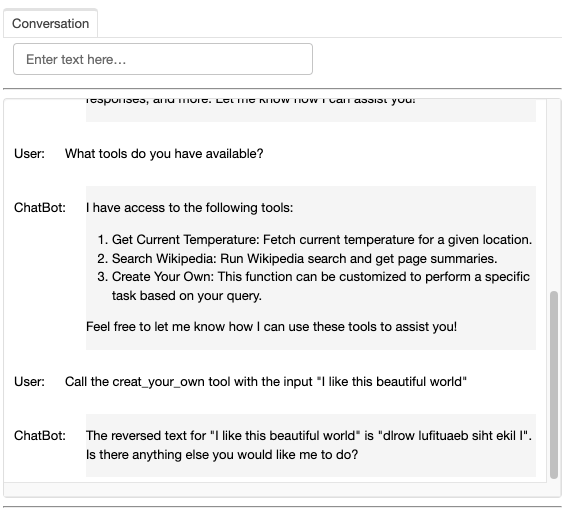

In [56]:
from IPython import display
from base64 import b64decode

# This is just a screenshot of the above small chatbot feature
base64_data = "iVBORw0KGgoAAAANSUhEUgAAAkgAAAICCAYAAAA03TKlAAABVmlDQ1BJQ0MgUHJvZmlsZQAAKJFtkLFLQlEUxn+WIZVGQy3RYEiQYREm5BbmEEGDaGY19XyaRmqvp1Gt0VZzc1N/QSDR0lg0BhW1tFVzIYTJ6zyt1OpcDt+Pw3cv537QYlU0LWMFsrmCHp6eci4sLjltz7Rjx4ELv6LmtUAoNCsWvrW5SjdYTL0eMd+KUR54Cj+8TL5fRqJ7V31//U3VkUjmVdEP6WFV0wtgGRIObRU0k7eFe3RZSvjA5FSNj0yO1/ik6pkLB4UvhLvVtJIQvhP2xBvmqQbOZjbVrx3M7e3JXDQi2iXdT4gAXibwE2Resvnf66t6g6yjsYPOKinSFHDKbU1OhqTwDDlURvEIexmT9pkZ/86uPttYA/8btLjqs2XJ5HQfet312aD8xbELZ4+aois/iVpK1vzKuLfGnUVoOzSM1xjY3FC5NYxy0TAqx9B6D+elTxITYqFI2vErAAAAVmVYSWZNTQAqAAAACAABh2kABAAAAAEAAAAaAAAAAAADkoYABwAAABIAAABEoAIABAAAAAEAAAJIoAMABAAAAAEAAAICAAAAAEFTQ0lJAAAAU2NyZWVuc2hvdJJhlAMAAAHWaVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA2LjAuMCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIj4KICAgICAgICAgPGV4aWY6UGl4ZWxZRGltZW5zaW9uPjUxNDwvZXhpZjpQaXhlbFlEaW1lbnNpb24+CiAgICAgICAgIDxleGlmOlBpeGVsWERpbWVuc2lvbj41ODQ8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4K0Ik7YgAAQABJREFUeAHsnQWYHUXTtjsQICQQglsCwQnuLsHdHYK7u7u7O0GCu7sHJ1iA4BIkuEvQF5i/7/qp+WYnx/ecZc/uU9e1e0Z6Wu7u6a6prpnukkQJEhEQAREQAREQAREQgZTAaOmWNkRABERABERABERABIyAFCQ1BBEQAREQAREQARHIEZCClAOiXREQAREQAREQARGQgqQ2IAIiIAIiIAIiIAI5AlKQckC0KwIiIAIiIAIiIAJSkNQGREAEREAEREAERCBHQApSDoh2RUAEREAEREAERKBrHsGff/4Zfvrpp/D7778HfSIpT6d++126dAndunULPXv2DGOOOWb9IlZMIiACIiACIiACrSbQJfuhyF9++SV8//33UoxajbXyCFCUxh9//NCjR4/KL1JIERABERABERCBhhJoMcX222+/STlqKO5RI8dKB3eJCIiACIiACIhA+yHQYoqNabXxxhsvjDXWWPbXfrLZMXPyxx9/BP6Y0pSIgAiIgAiIgAi0HwItLEhYM/CJQUGSNJ4AnOEtX6/Gs1YKIiACIiACIlANgRYKUjUXKqwIiIAIiIAIiIAIdFQCUpA6as2qXCIgAiIgAiIgAjUTkIJUMzpdKAIiIAIiIAIi0FEJSEHqqDWrcomACIiACIiACNRMQApSzeh0oQiIgAiIgAiIQEcl0OI1/2oK+euvv4bBgweHN954I/z9999h1llnDSussEIYY4wxqomm3Yd99tln7a2+ueeeu93nVRkUAREQAREQARGoD4GaLEgfffRR2HzzzcO5555rX94eMWJEOPPMM8OAAQOa/ps+Q4YMCRtvvHFK95ZbbgkPP/xwuq8NERABERABERCBjk+gJgvSkUceaeuIXXzxxfZhSTC99957YccddwyXXXZZ2H333ZuWHB9u/O6779L8H3HEEWG00WrSI9M4tCECIiACIiACItBcBKpWkIYNGxawGJ188smpckSRp59++rDnnnuGn3/+2Qj89ddf4cILLwwPPvigLXw79dRTh3333dfCvfXWW+H4448PK664Yrj++usDa8Atuuii4dBDDw3XXXddePzxx+1aR7nffvsFprg22mij8MADD4RLLrnElBjS3H///UPfvn3DtddeG7766qvQvXv3cOedd4bTTjvNjj311FM2BdinT59w2GGHWVgUoGOOOSadHuzdu3c46qijwtChQwNKH1OG6623noUnPdZK22qrrUKtZRp99NG9KPoVAREQAREQARFoAgJVm0bef/99K9acc845SvFWXnnlsMEGG9hxpt9QVHbaaadwxhln2GKsu+yyS/jxxx9NYfrss8/Mh+nYY481ixOKDIrR/PPPH4YPHx7eeecdi+frr782xQUF6bnnnjPFbNNNN7XpvQknnDDsvPPO4c8//zSF6d577w0PPfRQ2GyzzcLzzz8fiPOEE04I5513XujatWs46aSTLM5TTz01ME143HHHhbPPPjuMHDkyXH311WGBBRYIq6yyioVBmZtqqqnCl19+mVqUai2TRah/IiACIiACIiACTUOgagUJ68uYY44ZWIW+lKCsoMgsv/zyYeaZZzaLDeFRYFwOOeQQc+5eddVVw8QTTxw+/fTTMOOMM9o2lifkkUceCRNMMIHFgbVprrnmCvPMM08YZ5xxwjbbbGPK0ZNPPmlhsfxcdNFFYd111w3jjjuuWYLefvttW84DixXKFIIzOfvE1a1bN7M6ff/992GyySYL/fr1C1h8UJZYly4rtZYpG4e2RUAEREAEREAE2j+BqqfYpphiClNKeIuN6aysPProo+Gll14K2267rSknM8wwQ3qasChBWI6mm246O05cLqxLhoKDoDDdcMMNptCgUGGZQj7//POARQkH8aygWCFMlblSgxL0ySef2DQb02Y9evQwhYq37dhmipCpQhQp/I5QjkoJC8qSv1rLVCpunRMBERABERABEWhfBKq2IM0xxxxWgttvv32UklxzzTWmAKF0IChDLvjvYH2aaKKJ/FBRKxS+SfglMeX24YcfpgoSU2qcw7rkf0yhuQKF4uOC0kTY2267LVx++eVmLeJNOxSsgw8+2CxFlOHGG280a5FfV+y3tWUqFq+Oi4AIiIAIiIAItD8CVStIWH2WWmqpcOmll4abb77ZXvNnego/I5QZXvVn+g2na8LgkI21CeUEXyGuLSdMqWHpOfHEE81ig+UJwSqEYoQv0m+//RZ4BR9lp9BbZkyH7b333qakTT755MF9prAC8Uc58Et68cUXA1N0v//+e0iSxOLiPGVBqXNpbZk8Hv2KgAiIgAiIgAi0fwJVT7FRJN4c69mzZxg4cGC44IILrJT4JeHY7B9U3GuvvczvaNddd7XzY489djj88MNtKou3zZBSfkyrr766+QmtttpqFpZ/OFB/8MEHphSx36tXL3tzjrfMkGx8m2yySXj55ZfT6Tj8irbccktLH78o3oTjj3IsvfTSpnjxxhr+TViimCbkTbdsvK0tk0WmfyIgAiIgAiIgAu2eQJdoNUk8l/jk8Dp8pcKl+PmgHE0yySQtFBSPA6sRb4lhFaqX/PPPP+GHH36oKE4+O4AFi+k5LEYu5Im8eb6Y/kPRyipZHjb/W+8yVcs9nx/ti4AIiIAIiIAI1JdAqxSk+mal88YmBanz1r1KLgIiIAIi0D4JVO2D1D6LoVyJgAiIgAiIgAiIQP0ISEGqH0vFJAIiIAIiIAIi0EEISEHqIBWpYoiACIiACIiACNSPgBSk+rFUTCIgAiIgAiIgAh2EgBSkDlKRKoYIiIAIiIAIiED9CEhBqh9LxSQCIiACIiACItBBCEhB6iAVqWKIgAiIgAiIgAjUj8Ao30GqX9SKSQREQAREQAREQAQaS6CaD1xXk5MWClI1FyqsCIiACIiACIiACHRUAppi66g1q3KJgAiIgAiIgAjUTEAKUs3odKEIiIAIiIAIiEBHJSAFqaPWrMolAiIgAiIgAiJQMwEpSDWj04UiIAIiIAIiIAIdlUDXWgs2cuQv4ZNPRoQffvgh/PPPP7VGo+tEQAREoK4ERhtttNCrV6/Qu3efMM44PeoatyITARHoPARqeosN5ei114aFvn37hoknnjiMPvronYeYSioCItCuCfz999/h66+/Dh9++GGYbbbZpSS169pS5kSg/RKoSUF666237Altsskma78lU85EQAQ6NYEvvvjCLNwzzzxzp+agwouACNRGoCYfJKbVsBxJREAERKC9EqCPoq+SiIAIiEAtBGpSkPA50rRaLbh1jQiIQFsRoI+Sf2Rb0VY6ItDxCNSkIHU8DCqRCIiACIiACIiACPwfASlI/8dCWyIgAiIgAiIgAiJgBKQgqSGIgAiIgAiIgAiIQI6AFKQcEO2KgAiIgAiIgAiIgBQktQEREAEREAEREAERyBGQgpQDol0REAEREAEREAERqHmpkWrR8XXb888/PyRJMsql0003XVh55ZVHOZ49wHV802TccccNXbu2Ptu//fZb+Ouvvyy+bDrVbv/vf/8LI0eODOOPP37BSynziiuuGKaZZpqC53VQBERABERABESg/RFoMwsSCtKbb74Zfv/9d/vIJB9x87+ePXuWJYMyc8ghh4T333+/bNhKAtx1113h7LPPriRoyTBvv/225atYoNdeey18//33xU7ruAiIgAiIgAiIQDsk0HpTTJWFWmihhcLiiy9e8Ko///wzjDHGGGbZ+fLLL8NEE00UunXrZlanP/74w67hF2XJrUhc88033wSWPWGRSoSPwxFmzDHHDJzHWjTeeOPZOf5h9eE84YhvrLHGSs99++23FreHJwzhyZfHj7LneSB+hHiyYdII/9345ZdfwnfffWdKIWXKSjVlID+wmWCCCVrkOxuftkVABERABERABFpHoM0VpFLZ3XPPPcO8884bXnzxxTTYtttua8rNKaecYscuvPDCMNdccwWO33rrreGhhx6y4ygv66yzTujfv3/AqnPOOeeEtddeO9xyyy1h6aWXtnMe6Zlnnhk++OAD291rr73CUUcdZQrOueeemy5NMOmkkwbOIViuevfuHfbZZx9TjI488khT3Oaee+5w9913p/FsvPHGYdFFF7X97L8HHnggXHLJJekh8k4ZkGrKwDTdZZddln4deJ555glbbrllqrilCWhDBERABERABESgVQRGPyJKtTGMGDEi9OnTp6rLsLrcf//9Nt3EKtuvvvpq+oc1BIvNPffcYwrKgQceGFZZZRWbknvjjTfCaqutFhZccMEwePDgsMUWW5jCM3ToUFMudtlllzBgwIDQo0ePcOONN4Y55pjDrEbPPfecreaN0rLAAguYQuMZJszPP/9slqGDDjooMMV34oknhimmmCKQNhaup59+2hQttqeeeuqAkjPOOOME4h0+fHjYb7/9wowzzmgWIcpyzDHHhL59+46yBAtlouwHHHBAizKhyA0ZMqTiMkw//fQBBW7VVVcNlJkFOG+//XazkuHDJREBERiVQC191aix6IgIiEBnJNBmPkgO152acWz2PxQIF5y1mS5DGUEpQpFhTaVevXpZEJQZlCEUmKmmmsqOvfPOOwGLz9hjjx2effZZjypsttlmFodPl/kJ4iYsU2LE+8knn4Qff/zRrFdYlpjCwsKDJYqps379+oVlllkm3HDDDeGJJ54IW2+9tV3H1BxO4whO2kzpFRKctPNlIlw1ZSAv5BdljfLCcdppp7U4CqWpYyIgAiIgAiIgArUTaPMpNqa7ivkgUQxXhNgutdgkfke81TZw4ECCpoLi4FKpZQXfIAQLVFZQgH799Vfz9VlsscXCww8/bNNZKCbVSLEyVVMGwlK2fHnzyl81+VJYERABERABERCBwgTaXEEqnI3qj/IGHNaU7bbbLr2YN8aYrsMahGSdr9NABTZwBkeYbvNtlK93333XFDYcoy+44IIw+eSTm1KGP9Fuu+1WIKbqDlVTBsJi9Tr55JNDly5dLKGPP/7YFLjqUlVoERABERABERCBcgTafIrtiy++MB8e/Hj87/PPPy+Xz9QRGaWAaTecoV955RXzCeINMabWin1nqVDkOHX/9NNP4bPPPjMHbKw8OEDzFtvXX39tChE+Qigjd9xxhx3bcccdbXqN6a7HHnvMovU32ygL03HVSDVlmH/++e1tvJtuusmmJpkKPO200yz/pEn6F110kU0Xeh6uuuqqcO+99/qu+XwRBuVPIgIiIAIiIAIiUJxAm1uQcLTmLytYgnB6RlzhYBvlxPeZbuMtrttuu83eQONNMJSbyy+/nKBmXcGZe8oppzTFxw6W+DfLLLNYPo499lh7iw3HZxSsww47zK4iTxtttJGl9eCDD4Z11103TDjhhPaHbxT+SPgm4ayOT9Spp55q4ZmKy4uXgePZMs0333wVlwHLGGUeNGiQ5Zs4Z5999oCzN8IUHArjIossYgofx1544QXjsdJKK7EbcFglDJyy0352Uv9EQAREQAREQARSAl3iF6pH/bR1errwBs7FDMTtQcg+U2r1GvDxOUL5yH+rqJFlrbYMlBfn8Kzi1cj8KW4RaFYC7amvalaGyrcIdFYCbW5BqjdoLDL1Uo7IW/fu3eudxbLxVVsGOWaXRaoAIiACIiACItAqAm3ug9Sq3OpiERABERABERABEWgDAlKQ2gCykhABERABERABEWguAlKQmqu+lFsREAEREAEREIE2ICAFqQ0gKwkREAEREAEREIHmIiAFqbnqS7kVAREQAREQARFoAwI1KUi8Xp5dP60N8qkkREAERKAqAvRR+hRGVcgUWAREIEOgJgWJ1+r52rREBERABNorAfqoen4CpL2WU/kSARFoDIGaFKTevfuEDz/8MLBsiCxJjakYxSoCIlAbAfok+ib6KPoqiQiIgAjUQqCmL2mT0MiRv8R1v0bYul4s5ioRAREQgfZAgGk1LEcoR+OM06M9ZEl5EAERaEICNStITVhWZVkEREAEREAEREAEKiJQ0xRbRTErkAiIgAiIgAiIgAg0KQEpSE1accq2CIiACIiACIhA4whIQWocW8UsAiIgAiIgAiLQpASkIDVpxSnbIiACIiACIiACjSMgBalxbBWzCIiACIiACIhAkxKQgtSkFadsi4AIiIAIiIAINI6AFKTGsVXMIiACIiACIiACTUpAClKTVpyyLQIiIAIiIAIi0DgCUpAax1Yxi4AIiIAIiIAINCkBKUhNWnHKtgiIgAiIgAiIQOMISEFqHFvFLAIiIAIiIAIi0KQEpCA1acUp2yIgAiIgAiIgAo0j0DUb9RlnnJHd1bYIiIAIiIAIiIAItFsCc8wxR1h66aUbkr8WChIJ8ScRAREQAREQAREQgc5MoEsSpTMDUNlFQAREQAREQAREIE9APkh5ItoXAREQAREQARHo9ASkIHX6JiAAIiACIiACIiACeQJSkPJEtC8CIiACIiACItDpCUhB6vRNQABEQAREQAREQATyBKQg5YloXwREQAREQAREoNMTkILU6ZuAAIiACIiACIiACOQJSEHKE9G+CIiACIiACIhApyfQ4kOR0Pjzzz/DDz/8EH777begTyR1+vYhACIgAiIgAiLQrgh06dIljD322KFXr15hzDHHbFze+FCkyx9//JF8+OGHyXfffZf8/PPP+msFg3vvvZcPcBrLX375Jdlzzz1tn2PZv9VXXz35/vvvk8MPPzyZZppp7By/gwYNSrhuzTXXTPbff3/bZp8/9hdeeOHk5ptvtvA//vhjev6rr76yY3fffXey/PLLW7x+neeJfep5yy23TMYZZxwLv+iiiyZPPfVUGmc2j2wTjusuv/zyZN5557VrOEZefvrppzR9Tyv7S3ui/FNOOaXFQ96J8+WXX04effRR286WgbycdNJJyU033WTnaIse30cffWTHXn311fSYn6O8RxxxRHp8t912SzbccMN0/7zzzktmm202259rrrmSww47LD1HHM6V/JI/eHHcORdj4ukX+t1nn30S0ip0juP5ONk/5ZRTki+++MLOPf/88wWvJdyDDz6YnqNclM/TodyU/9NPPy2YBtc/99xzaXiuGzp0qIWlXvmjzjy+Y489NllyySXTfWdEm9lrr72SxRdfPD3HNXfccYfF9c033xg/4vO8PPvss3bOy/jiiy+2uJbrS7ULr49sm8m2+xEjRlj8lI+2yr0w8cQTJ4899lgSlyRIzj777FHSo43BxO87Lze/e+yxR7LsssuOcg3nam3b2fjLxVOqf3j66aeTFVdc0fJO/tdbb72Ee8TrEubF7nXS3XvvvZN11lmnYNk4z7ltttkm+frrry2NwYMHJ5999plt33///S2uW2CBBZKDDjoorbtsv+D3NHEeeuihySWXXNLiWo7rr+MxqFSP+OSTTxL0j2r/uO+5plHSwoKE5ahnz56hW7duYYwxxgijjTZaQFOT1E5grLHGsoujchDigBjigJJG9uabbxrnjz/+OKy99tphv/32C7FzD3GADFtssUW6vsx7772XXsNG7ADD5JNPHiaZZBI7zjVRqUq32fBzxeqPNKNSFs4666wwbNiwEDvKsP3224eLLrrI4omdYBhvvPHSbfZjJxmmnXba8Pjjj5uVMSowYffddw9xEAqrrLKKhS3077LLLgtXXXVViB1qmGmmmUIcGMN0003XImihfHoZ4s0TpppqKgtPWeshU0wxRYgDR4uohg8fHjjuMu6449omrJFCTOxEjf969+5tdXz00UenMTzzzDNh+umnT/dbu+F1GJWKEAdSiy4OROGll14KM8wwQ8Hoo3ISXn/9dWuDq666alhooYUKhvOD1BPs/vnnH+szOE4bjUqRPeVFxSqMHDkynH/++SEqx2H22WcP3A/nnnuu5WHmmWf2qEb5LdUuirX7CSaYIESFJtx2220hKl9h/vnnDyuttFK47777wiOPPJK28VESK3IgKldWnuzpCy64wNok91EtbTsbF9ul7pFi/cNiiy0WqMtrrrnGrP30LRtvvLH1DfHhJ02i2L0+ZMiQNEyxja222ipssMEGISo4VlewpJ6R7L34119/hQ8++CBMOumk6Zjx999/h9FHH93Ccu+40AYmnHBC39VvBybQo0ePikoXH3YqClcoEHqLjxWFzrfmWAsfJKbVGND569q1a6og0UnprzoG+UphcIoWkxCfnMKvv/5qHfd8880XPv/888Dgte666wY6MgYOOiHEOxfO09lz3QMPPBCuu+66EC1PNtAwyEUrRYiatMW17777hmhNMEUkn4fs/sEHH2xKEQMXA1S/fv2szmeddVbrCA844ABTgshTtEaEaK0Ib7/9doiWAlPyGHjpoBHySTiuee2117LJ2DZ5Y7CcbLLJLM7jjz/ejlOeUjLnnHOa4keZoiXCynfggQeWuqTic/FJO1xxxRXhnnvuCb///nu49dZbw4033hg4npdSTAh76aWXhtNOOy1/WbrPIIYynP1DgaDOUUiffPJJq1sG2mgxNJ48nCDvvvuuKRdpZFVucN9GC0BACXv//feN/yGHHBKiRciU80LRoSTCAeWIa8vVE8pxtFQE6pWwr7zySjjqqKOCD9KYwtdff/1wzDHHhGWWWcaSRIEhTzCoVlCwyrV7OB533HE2sNNJo6SRPwZnV3grTXe55ZazekAp4n6JlkW7d/r27Wv3XS1tO592qXukWP9A3ZK3Cy+80NrMPPPME8gTfXdWit3rhCEsDyzUXyFZYoklAgrirrvuGrbddlsLQttEceIBi/ud9n3kkUfaAxSKKEoScvXVV1t7oI2jPLlEq2h44YUXfFe/HZhApXpDaxCgtzRKWihI0UyVWo4alWBnjRcLD4oNgwIdTjRdh2iONoVjhx12CFNPPbUpKVgtsOacfvrpNr8KLzr1aOa369Zaa60Qp4LM4oSV74YbbrCOifixPNBYeKJEaaEj84E2z/3kk08OcZrKBgueuLHucIwO89prrzULA8oaihOdbpyuscGG3ziVZQoPlqPNN9/cBj062Th10aIj9DQ32mgj821j4CXO7t272y/Xev64kfJCXlBasKDBh/KVevLMlxcG2Xg9LdJhYD7iiCNMESDOAQMG2IC62mqrpdnw8KWYEPj222+3wSC9MLNB+ig5KMPZvzgtZW0AniussILVLXXOYEd9MKijRGARgGsh8fxxjjxm97PlZvDC8sdC1PBHUUOhy4YhDt/33zPOOMPaFooGcbvCTtisEDeD+MCBA60ciyyyiJUJRcxljTXWsE1Xqvv372/7xSyPXhbPi8fDb7l2TxgGamSppZayXywgCIpTKSlURhTkiy++2BQCBn8U9hNOOCHMMsssoda2nc9DqXiK9Q88cKCco+zii4FFkv5jp512alGXxe518sADDwrtjDPOaPdoPl/Uw9Zbb22KIUquC8ouTBdccEF7er/++utDnFa19oW1d5dddrE/+ro777zTwvq1PAhwTCIC9SCA3tIoabFYLVMONG7vnBqVaGeIt9RTN1NVDMp5znHO3p7GJppoovTpfpNNNjFrEIPNl19+aQMQg2FeuJb4eJqtVGhY3377rZnM6cjygxFmT6yJTLlmBSUs+kVYp4yy48IUHQM/02h5wdzOU7KXjTg4Vml+SQ9LRD4v+XSq3We6gPqg/Pn6KBRXMSaFwlZ6DA6UDzaNFJjzEoZPuzUiLVgSf0MdJzMZr6XdZy6vapP7BUsmbSUrrW3bHle5eAr1D1zL9Bbc3WnV48v+lrvXs2Hz21htmea+8sor86dC9P8I0c+kYNvlXiFdlDdJ5ySQHR9KEcCCmb+vSoX3c7QxLJg8xDdCRhlp84NkIxLt7HEWawj4f/FXSBi8S00NFLuuUFx+jLouNSgXG0jpiPnLClYJysWTaCHhyTyb//z1ha7JHht//PGzu3XbhqtPCVQSaTEmlVxbLAxsStVDseuqPV6o3qqNo1z4Ym273HW1nq+l3deaFvdLofK1tm17fsrFU6x/4IEpe295fNnfcvd6Nqxvv/XWWza1j5/iQw895Idb/LpLRouD/+404l4plI6OiUCjCIyiIDUqIcVbGwGmJhqlHNSWo8JXMRWH2V0iAiLQMQhg0WJ6G79JpvklItDZCIwyxYavh6xIrW8GpabYWh+7YhABERABERCB9k2g2afYWjhpt2/Uyp0IiIAIiIAIiIAItA0BKUhtw1mpiIAIiIAIiIAINBEBKUhNVFnKqgiIgAiIgAiIQNsQkILUNpyVigiIgAiIgAiIQBMRkILURJWlrIqACIiACIiACLQNASlIbcNZqYiACIiACIiACDQRASlITVRZyqoIiIAIiIAIiEDbEJCC1DaclYoIiIAIiIAIiEATEZCC1ESVpayKgAiIgAiIgAi0DQEpSG3DWamIgAiIgAiIgAg0EQEpSE1UWcqqCIiACIiACIhA2xCQgtQ2nJWKCIiACIiACIhAExGQgtRElaWsioAIiIAIiIAItA0BKUhtw1mpiIAIiIAIiIAINBEBKUhNVFnKqgiIgAiIgAiIQNsQ6No2yXS+VLp37975Cq0Si4AIiIAIiEAHISALUgepSBVDBERABERABESgfgSkINWPpWISAREQAREQARHoIASkIHWQilQxREAEREAEREAE6kdAClL9WComERABERABERCBDkJAClIHqUgVQwREQAREQAREoH4EpCDVj6ViEgEREAEREAER6CAEpCB1kIpUMURABERABERABOpHQApS/VgqJhEQAREQAREQgQ5CQApSB6lIFUMEREAEREAERKB+BKQg1Y+lYhIBERABERABEeggBKQgdZCKVDFEQAREQAREQATqR0AKUv1YKiYREAEREAEREIEOQkAKUgepSBVDBERABERABESgfgSkINWPpWISAREQAREQARHoIASkIHWQilQxREAEREAEREAE6kdAClL9WComERABERABERCBDkJAClIHqUgVQwREQAREQAREoH4EpCDVj6ViEgEREAEREAER6CAEpCB1kIpUMURABERABERABOpHQApS/VgqJhEQAREQAREQgQ5CQApSB6lIFUMEREAEREAERKB+BKQg1Y+lYhIBERABERABEeggBKQgdZCKVDFEQAREQAREQATqR0AKUv1YKiYREAEREAEREIEOQkAKUgepSBVDBERABERABESgfgRqVpB+/fXXMHDgwPDZZ5+Nkptrr702DB06dJTj7fXAddddF5577rkW2bv99tvDLbfc0uLYK6+8Eq644orwxRdfWNmTJGlxvj3tfP/995bHP/74o1XZ+uijj8JVV13VqjgadfHdd98dXnrppUZF3+bxwvnDDz8Mldbdd999Z3X8119/Fczrm2++GW6++eaC5/IHhw0bFg477LCw++67h1tvvTW057adz7v2RUAERKARBGpWkH744Yew3Xbbhffee2+UfO23337hwQcfHOV4ez2AgnTCCSek2fvf//4X1lxzzbDOOuuE33//PT1+xhlnhGuuucYGMcr+zz//pOcq3TjxxBNtECoUfuTIkaFPnz4FmRYKX+rYl19+afWDItsaefnll8Pee+/dmigadu25554b7rvvvobF39YR77TTTuH1118PldbdJ598YnVcTAl+6qmnwnHHHVe2GM8++2yYY445rF3/9ttvYe211w4nn3xy2esUQAREQAQ6MoGaFaSOBGXZZZcNDz30UKrwPP/882nxspale+65J6ywwgrpuVo2UCyxQBUSFC4GvaxSViicjnVMAiNGjGh1+6qFzGmnnRa22mors45edNFFYa+99gqXXHJJLVHpGhEQARHoMAQariA9+uijYd555w1dunQJk046aQtLDWb9ZZZZxs4tvPDCgSkTBAWF4/fee2+Yc845w5VXXhl23HFHs+o0gvwSSywRfv755/D2229b9I888kjYcMMNwyqrrBLIP/LBBx+Er776KvTv39/2+XfssceGnj17Wv6333774FMd5H+xxRaz45zfYostAk/me+65Z8DqccMNN4RZZ501DU9cb731Vph//vnZDGussUa44IILbPvVV18Nyy+/vMU13XTTheOPPz69DkvXUUcdFThOOiuuuGJ444037Lrsv48//jisvPLKLfJTzLL09NNPB+qC+iKPKI4ulab39ddf27WDBw/2SwPTk8THtNA333xjTGgP/G2zzTY2rUTgyy67zPb9wj///NOug08hweLirGeaaaZA/pG///47HHjggRY/ZeEc1ibKTXv0tkZYruEYium3335reYMn12DxKyS1xl+sbZDGaqutFrD65IWpN/Li91DeukMesTyS50022cT45uOgbR5zzDFpOJj/8ssvFmz22WcPm266aXrJ5JNPbpzSA9oQAREQgc5IIPoapBKVgCRaMdL9UhuffvopDjjJY489Nkqw3r17J7HTtrgmmWSSZLfddkvefffdJPom2TXRKpPEQTIZd9xxk0MOOSSJg1xy9tln27k4kCZRQbFt4olPtwn5IlxUkkZJqx4H4uBheYlPzRbdoosumsSBOjnnnHOShRZayI7FQcrCEPaZZ56x/EVrUhJ9YNJy3XXXXRaWMkcFK6EsDz/8sIW97bbbrJzrrbdeEpWsJCoPSRxk0+xHBS3hepheeumlyfDhw5OokFmacfCyuKJiZftx2sSuO/TQQ20/+pnYeeKGaVRCkuh/YnGxPWDAgIQywTkOwAn5O/XUU9O0fcPrNE71WHyUmfwQHimVnsfhvyuttFISFUPfTQ444IBkueWWszZBXuaZZx7LyxNPPJHMMsssdo7AJ510UrL00kun10WlxfLw4osvpsd8gzTI3+WXX55wnvogXoRjnLvjjjuSqFwlMCQdBE78uey6665JnE61vFE3UTG28t95553GMyqrHjT9rSV+Li7WNjhH3dEGsnXHfUM5omJs5YjTvLYflVDLI+fi9Fjy5JNP2h/blAGJPoIpj6hIJ9NOO621uyFDhiRRGU/WX399C5f9R3rkg/QkIiACItAWBOLMSRJdBar+Y4xEP2iU4IyZCgnVU0EiYjplBi4GZga7F154wQb+888/P0EBIs3omGp/iy++eBL9XVIFKVov0rw1eoPBggE9OsjaABSdk5PXXnvNtlEydthhh2TjjTe2bLiC9P7776fZYmBGoYpWlgTFIvqRWHkZjBhwLr74YguLolBoYOLkjz/+aOlFy5qFjdYmG1Cj9cn2+YcC4QoL8ZKmS/RhsrRQsLKDbPSXMtYM+HGKz5TV6Dvml6W/Z511lsVNGVyOPPLIitLz8P6LQsjgTZ5QBKlrFGSURo7z6+I833nnnaoVpDg15NGkCiYHUFyjH5yd+/zzz5NddtnF2HDAFdGffvopQeGFZ3TKT+BO3qJPTtomqS+UjrzUEn+5tlFIQUJphRsMqTtXzFD6nCVtzIWHD8qAopNVkIgb5crvtfgCgoVD0XKhncNi2223baG8+3n9ioAIiEAjCLRXBalr7ExrktFHH92uczN9NpI40Ke7N910U4iWhxCtBnaMqas4ENuUFf4200wzTRqWjYkmmijdZ+qkrSRaLWwKIj6JhxlnnDFMNdVU9iZPHDACxx544AErRzY/hHHp0aOHTX117drVpmqitcTKOPPMM3uQqn+ZGotWj9CtW7f0WqYcmerDj4lpQaZHXMgD01i8ecY0mcvRRx9tZYkKnl0TFdGAw3le8IEhfsrggvMugu9UqfQ8vP8ypQe7qJQZS9rE6quvnk5ZUi4XLwPlrVaiAp5e0r1793R7wgknDKeccoo5HI833nhhggkmSM8xZRkVhoBP2ZRTTmnTn/iW+XRitBqmYdkgbF5qib+WtkE6vBG67777Bhh6fWTzQ527+DZtwIW34qi7PfbYw/78OL9ReUzvOV5AGGecccJ5550XRhut4bPv2WxoWwREQATaHYGae8GJJ57YCsMAmBU6czpjlAferkGB4lVjfHDuv/9+8/3gjbFoUQjR6mIDd9RI7TdabFr4fIw11ljZqBu6jR8SChtOqquuuqqlhc8HfiE4rMYprxCnLlrkgfN5ofz4d+AbhFKBkzc+HbUI/jm8JYjztku0ANiAjfKBZAdC/EzI52STTebB0zD4n5AfXosnvi233LJFGHa4LlrFRkmPc/i3IJWkR7gxxhjD/Mbwn0FJJj0UGMqEZJUhj5NzMMXXyQVlsJQUqgPCowygREYLZUDxQ0l3IW/RIhiuv/56+5QDeaOtTTHFFBYEhcLbJG3CFSe/nt9a4q+lbfApjUGDBpmCHi1e4cYbb8xmw7ZpEy6UFfH7k+1evXrxE6LlLC0Xb0ziX4dvkwv1A4usguzn9CsCIiACnY1AzQoST5hYJBgA45SOvZqMs+vBBx9sDFE4GIixVuCYjMVpvvnmM4sRAxQO0AzWF154oTmE4rw622yzhTilULAOUFyKOcwWvKDKg1h63OKB9ceFbb6JhKWib9++frjoLw7KCI7TKIgoV3HqKHV6ZfDhqZ2BNy9ulSM8AxgWF8KhbOFczADLQI8CBn8+NXDQQQcFHLlRRKOfllmXXMHz+PnsQvSzMcUVyw1WhkKDIM7hKFg4ghNf9OuxbeKpJj1Pd/PNNzeFOE4vBrYRLFRY6KJfmrUZvqOFsoFlpF+/fqZMRr8kKysKXVax8Xgr+YUx1iEUO5S+6HNll6FEItEvy773Q95wbEawZJE3PmuAkoTittZaaxX8lEAt8ZdrG5aJ3D9e+ceqg5JNnmgLSNbJnvzCEef3/fff38qQtdChRKIQ8p0jFG7ioU3E6VNTZD1JHOLHHHNM39WvCIiACHRuAtn5xGp8kLguvvFjfjmRoPkz8Iuvift+EAZ/HPwfPAwOuvhVIPGDdObzwLmonCSHH364HXcnbdv59x9+TLHTzx6q+zaOvOQFvxmXaIWwYzjyuuDzQbiskzX+U/h4RMXCnGS9vDgSx0HWwsdB1dg4D5zS8kI5uRbfHwR/Gdh4fPhJRQudnYsDXQv+sI9WOjuHjwrXECZ+yyiJA38aB+Fwji4kOHx7/rgeh2XSR0qlVygujlGevA8P/lE4CXuZaBP4zCCwZ9/PxYHctgs5aZO3rDNxtt1ES0saB+WJFjTbxxfJhXzBJet3h98Zxz19/MWy7cGvrSX+cm2DfFLf2bpjm/ry/OCjxz75dh8kfOP8PPeI+7BlfZDwL8Ix3cNFa2gazssET+KViIAIiEBbEoiGgKodtBk/G+2k3QUIsdM0wVQ/9dRT2zSHH6vkl6dZTPuxg7cn3fy0B0/tTJWMPfbYYfzxxx8lSs7he9SR/B4oE1MWPP1jSeOpHX+SWoX4mCop9ISPpYrpl+y0Sj4dqhkLA3nBUpavo2x4wmK5ID63amXPV5Keh8dixCcQ+AhiXvCpoc5pN3lhegzfIdpMrcJr+1ExsKlD0sEihZ8WFsxyQlh8v7L+X/lrao2/2rYRFfG0Psg709Uco225UP/cZ1lfKz+X/eVa6s+n3bLntC0CIiAC/wUBZo5KjV/F8sQYwmxHJbM7xeIodbwuClKpBHSucxLAbwffs6uvvtqUZ5QdiQiIgAiIgAjkCbRXBalmH6R8AbUvAlkCWMywsPD2n5SjLBlti4AIiIAINAOB/3ufuxlyqzw2DYHo7xL4k4iACIiACIhAMxKQBakZa015FgEREAEREAERaCgBKUgNxavIRUAEREAEREAEmpGAFKRmrDXlWQREQAREQAREoKEEpCA1FK8iFwEREAEREAERaEYCUpCasdaUZxEQAREQAREQgYYSkILUULyKXAREQAREQAREoBkJSEFqxlpTnkVABERABERABBpKQApSQ/EqchEQAREQAREQgWYkIAWpGWtNeRYBERABERABEWgoASlIDcWryEVABERABERABJqRgBSkZqw15VkEREAEREAERKChBKQgNRSvIhcBERABERABEWhGAlKQmrHWlGcREAEREAEREIGGEpCC1FC8ilwEREAEREAERKAZCUhBasZaU55FQAREQAREQAQaSkAKUkPxKnIREAEREAEREIFmJCAFqRlrTXkWAREQAREQARFoKAEpSA3Fq8hFQAREQAREQASakYAUpGasNeVZBERABERABESgoQSkIDUUryIXAREQAREQARFoRgJSkJqx1pRnERABERABERCBhhKQgtRQvIpcBERABERABESgGQlIQWrGWlOeRUAEREAEREAEGkpAClJD8SpyERABERABERCBZiTQtRkz3Qx5/vXXX5shm8qjCIiACIiACDSEQPfu3RsSb1tFKgtSW5FWOiIgAiIgAiIgAk1DQApS01SVMioCIiACIiACItBWBKQgtRVppSMCIiACIiACItA0BKQgNU1VKaMiIAIiIAIiIAJtRUAKUluRVjoiIAIiIAIiIAJNQ0AKUtNUlTIqAiIgAiIgAiLQVgSkILUVaaUjAiIgAiIgAiLQNASkIDVNVSmjIiACIiACIiACbUVAClJbkVY6IiACIiACIiACTUNAClLTVJUyKgIiIAIiIAIi0FYEpCC1FWmlIwIiIAIiIAIi0DQEpCA1TVUpoyIgAiIgAiIgAm1FQApSW5FWOiIgAiIgAiIgAk1DQApS01SVMioCIiACIiACItBWBKQgtRVppSMCIiACIiACItA0BLq2Nqe//PJLuOuuu8JLL70U/vrrrzDffPOFddZZJ4w55pgW9d133x0mn3zyMM8887QqqY8//jjcf//9aRxdunQJ44wzTlhggQXCtNNOmx5vTxuDBg0Kiy++eJhuuulaZOuVV14Jn332WVhppZVaHNdO4wl8+eWX4Z577glbbLFFoA21Rj7//PNw7733hkkmmSSsuuqqRaP64Ycfwq233ho23njj8Ntvv6XbY401VtFrqjlx3XXXhYUXXjhMPfXU1VzWZmEfe+yxQFkXWmihNktTCYmACIhAawm0yoL03nvvmYKy2267ha+++iq8++67NgjMP//8gUEBOffcc8N9991XdT5HjhwZ+vTpE0gDeeONN8J2220XrrnmmnDjjTeGa6+9Nuy+++6mfDz99NMVxX/iiSfaNRUFbmWgf/75J+y8886mOOajevTRR8PZZ5+dP6z9IgRoCzPOOGN4//33i4Qofjh/7UcffRR22WWXQP20VtZcc82AEvzNN9+UjIp7gzRRjrLbJS+q4iT3wZtvvlnFFeWDnnbaaWHfffctH7CCEDDiIUoiAiIgAs1EoFUWpG233Tb07NkzPPnkk2H88ce3cqPIzDrrrOHUU08NRx99dM0sGMA++eST8Pvvv7eI45ZbbknT+t///mcWq4EDB4ZFFlmkRbhCOyhtX3zxRaFTOtaOCSRJEj799NPwxx9/VJ3L1lxbKjHa5WuvvRYGDx4ceCD4L4UHk+7du9c1C9wrWNskIiACItBZCdRsQXrhhRdscDj99NNThQWIs8wyS8DkP9VUU6VMX3/99bDYYovZlMZMM80U3OLz999/hwMPPDBMOumk6TmsTW+99VY66KyxxhrhggsuSOPKbowxxhg2MGQHB6xL8847r8XH7x133GGX7LnnnmbNuuGGG0yBYzpwxx13DFgB/gvBsrHllluGHj16hL59+4ZLLrkkzQb85pprrvTcGWecYee22WabcNxxx6XhiGPBBRcML774ok1vYiHD0gLPnXbaKTD9WUgIv+yyy1r8hMUyh3UDwcLB9BPHPR7SQYYOHRqWX355u450zjzzTDvOP+p45ZVXtnNLLbVUajVEkYA9cVHWFVdcMbUKPv7442HRRRe14zBAqc7LO++8Y9OUHF9//fXDxRdfbEFQlP1afpnKzUuxawl30kknpXnaddddjR/Hv/vuO+NBfqkDLCl5wQpFmsgmm2xiViS2K8kT4bJS7JrLLrss0PZduM+WWGKJNJ+04w022MBOr7vuuuGZZ54xhY165YFhttlmM67ZslG3m222mZWbsp1yyikWp6fhv/vvv3+48MILw80332z3EvcKDyPHH3+8xQsb8sZ96oKyuNpqq1mapE3cXJcX4qXt0Ba4P926PGzYMNvHuioRAREQgfZAoGYFCUsRwgCdFzpurEsuTIsxCDMwTzPNNIFOG7n66qvDCSecYIMenS1x7b333qF3797pwHTIIYeEFVZYwaOyay699FKbomLAHD58eEBxQB566CEbRDfaaCMbLPCFoiN/6qmnLD8Mzv379w/nnXdeGG200cJEE00UpphiijTuttyAxZRTThmGDBkSNt1008A0JYMz00hbb721HXv55ZdtmuPggw8O3377rfFBKfGBh/J++OGHYY455rAB6corrzRFC2WBAQsFsJDABcakzUBLPTz88MMBawt1hwJw55132nQm/jpYAr/++mtTcvv16xeeffbZQJ4OOuggU0DJ99JLL20+JpSLOEiDPFx//fUWD/GhVKPUMgCTFoM1lr9XX301nHzyyeGwww6zNpLNM/VDG0G4DgWAQRRm1D9xouSyjZKQlULX+nnK8MADD5hyQ3uCJXnCTwjW8EAhQOnMKq9cj88RChaCgo9CWGme7KJ//5W6Zu6557Y8URcIPkywhanvzzDDDLaNTxvK8K+//moMmM6iTgfFqa1s2dZaay1TgFFKyD/MiTMvKO4owvjPoZxzr1AHbB977LHGBsvxkksuaVPpTDEus8wypnjRpo466iiL2xV7jx9L11577RWOPPJIq3N88GgnKF/4LPJQNfbYY3tw/YqACIjAf0qg5ik2BkwGikocXbfaaisbDCkpypE7tM4+++zhwQcftEGPqa/xxhsvjBgxwpyv6ZwRpi9Qqt5++23bZ0BnkEVQDhCmXxhQLrroIutw99lnHzvOVB/Tfzy1XnHFFeavRH7p2JHWTAFaBK34h3LEQMLg4woh5UBpY2Bj4MBy41OXKCFrr7122GOPPcwChzXhtttuC7CFBxYGFAx31IUBiiLHJ5xwwjSnKFcM+ig0DHJYeHB2RynACvTcc8+Z3xSWPgRrFg7lDNATTzyxWXm6du0aqLtxxx3X2gBWEOpu8803t/aAJYljDNLUC+VgYEdBZcAmPneyx8pDW1p99dWtrvA7ywp5c2sNFgcsTYceeqgpRfjeIChtWCVRZHBWdil0LVYUhMGbdjXnnHPaNooIfjxPPPGEWUZhQ/vZfvvtrV2htLowiHueePkA5ijyKGqF8rTffvv5pS1+YVHsGqxAtBEcnFHyUWS4b8gf+cIyihJXSAqVDf4o3Cij/tIAHFE68zLzzDMbG+rI78NzzjnH2qtbtbDq8nIEii/WR5gQplu3bmZl4qUK8uH3ImlwDkGho12gYFPvTKfT3mhjEhEQARFoLwRqtiAxKDDY+PRLtkBYMA444ID0UPYts+x0GAM3UwkMRihCTLmUk9tvv90GBgYHrC1MJTF40cmyz9RBVhhUsTK1N5l++ulNOSJf/tTMlOMEE0xgAwiDFBYCBlEXeKEkoXxgLWA6EWsN/iLUAwMxygJ/KEdI3ucK5QaliMGWJ3ae6F1QThG3TLDNm0ekiQKBMsH1LhznPIoqyh3Tq54+VjuOowAcfvjhZhEkXqwtKEUIChTxYX2g3NkpO0+j0C/1idUsKwy4pFepZBUxpntQHBnUkf7RyujlYNqvknhryVOpa1BOsIrxAIHSiuKHcjI4+jxhNUNZLeb7VKhsXrfZe5E2WIn8+OOP1r5QzFxgRn3DjLhpr64AEQYFGsXXp245Rr4uv/xyU2a5L1FQsWZl2xThJCIgAiLQHgj832hXZW68c77qqqvCDjvs0OJq/DawhLjQ2RcSrCF0vh988IFZOW666SaziBQKW+wYnTyKGmZ+nriJKyu8BcfxZhEURpjySQOeqlFw/ImfMjAFhI8QFiQUDhRCpoYQfEaw0iBMufDphayyw3Ge3lEqmfrC0oMFy5VKtzThnMunGRAGaCwrDMg+3WMn4j+sCChZ8CUOlCIXrsGyxQCKIoXyxkCKbwr5xyeNPDL9Sv65lrKRLlNbpYSps7zSgrJRzXRpoTbpZcbChUUMYZu/clJLnspdgxKLUgRjLH4oSUxd4+ODhXH00UcvmK1CZaP+EOrDrYxZH6KCEf17EEsh4koW2yiU3Gv4I6EEwZ+HFNoTQlvBgufKP8dQmFDQeBBCqed+x+KGsrTKKqsQRCICIiAC7YbA/+/NasgOnSx+M/i5MKgzRcMfvimPPPJIOtVQKmq+I8PgigUJ64876dL5euePtSFrpWLgZSqIPzpYnJaZ5mC6D6sJFhfM/lhJOM8UkVtTeFIlTd6OQ5iSY7qpPQnKHgPLZJNNZoOIKwtYjBCsLQiWH6bXEAZE/LCYMoQjgw9TPviL+HSkBYz//JV0BireCuOJHt8Q4uepn4GUa4kDZQoHa6x+yy23nIVDKaI++P4P/mJ945QXShnTN0xxEQ/TQXwPC9YobTgRMzBT165Yk2fiZPqTuqYOiauQNcEHXfJJ2uutt55NmeIfRT0zNYM1jeN5yV+bP5/dx0KCQon1k/KT5w033NCUxGy4QtvV5MmvL3cNrFAwmKpCocTiAkOUTJ+m9rjK/aLAcj1lQ7Fh6s7bVqFrqQeUcyyDMKStYQlkqg7FFj8iFB78iFBuCEd81D/thuljfJmywjQ5U3YowyiglAmh/mFN3tzHKnudtkVABETgvyBQs4JEZlFojjjiCFOGsBjxx1tGTAH5a/d0rj5I5QvIAItjMQ6aTJHQ6f/88882KGPCxzmbJ2UsUh4Hvh88QfPHAIN1hUEYYboJpQC/BgYWzuOIyjQPgu8RAzmm/j///NPyiW9SI8UVvWwalKXQccKgzJE3rAsMhign/OLfg8CKwYrBCTYuDFgoPUw9ER5FEm55awJWCAYpBl/qCz8meOEr8tNPPxkTFBziwFEXp2je1EJ5oG4ZJLEa8I0cHHeZZmHgRRFFQUPBIl/4l5AO1kWUaaassERQ5/hFoQCizFJfvXr1Mj8szmPdygttgXxgYeL7UShctDvqF6vXgAEDTFHmLaq85K/1dpTnwnUoBXxfC8sb5SfPKG08CJSTUnnytPjNbpe6hvRoI4RBUDgR7omsb5Ud/PdfqbKhKHNf0m64d7BE8UdchYS6Q9HhjTPa4zHHHGN+V7xIwcMIFkj8oOBEu+MexG+K+ufeJ58o2i6Um3sXlrQr0sVyRLtG6UcZo27zlkG/Xr8iIAIi0NYEusTpjf8/PxNTpnNiMPNOvNLMYFrnWnwQmKao5nosADggM2DSwfPkzqCWt3xUmhfCkR8sMXTkPmhUc309wrrFp5a48EUi/ygwcGAKg2PFBrNsGoRlQPMpouy57DYDJUokccIL7vgBuVAnWPbyFh2aC1Yon7Lx8P5LvCgtee4oX1gevEweHmuh5wVFqRoh31xLXvLpVRNPobBM/fL156xfTaFw+WO15KmWa/LpltunTfCCA9Y+6hVFG0UV61slvn8eP1ZHHmKox0JCfdD2iL+Y0Ea///57U4yzPonFwuu4CIhAcxKo9P7GAl1sTClVcvppxhUeZBshdVGQGpGxZo+zNQpSs5dd+W+fBLDg8PCB5YgpLd56ZMqUTyZIREAERKDeBJpdQWrVFFu9YSo+ERCBxhHANw+/L37xw8NHT8pR43grZhEQgeYmUPNbbM1dbOVeBDofAaZQ67W+WuejpxKLgAh0NgKyIHW2Gld5RUAEREAEREAEyhKQglQWkQKIgAiIgAiIgAh0NgJSkDpbjau8IiACIiACIiACZQlIQSqLSAFEQAREQAREQAQ6GwEpSJ2txlVeERABERABERCBsgSkIJVFpAAiIAIiIAIiIAKdjYAUpM5W4yqvCIiACIiACIhAWQJSkMoiUgAREAEREAEREIHORkAKUmercZVXBERABERABESgLAEpSGURKYAIiIAIiIAIiEBnIyAFqbPVuMorAiIgAiIgAtN0ixsAAEAASURBVCJQloAUpLKIFEAEREAEREAERKCzEZCC1NlqXOUVAREQAREQAREoS0AKUllECiACIiACIiACItDZCEhB6mw1rvKKgAiIgAiIgAiUJSAFqSwiBRABERABERABEehsBKQgdbYaV3lFQAREQAREQATKEpCCVBaRAoiACIiACIiACHQ2Al07W4GbobwPPPBAWHjhhcO4445bcXZ//fXXwHUvvvhi+PPPP0O/fv3CuuuuG8YZZ5yK4ygX8JVXXglPPPFEeO+998KUU04Z1lxzzTDDDDOUu+w/O//CCy+EYcOGFU1/8803D6ONpmeEYoD+97//hauuuqrg6bXWWiv06tWr4LlqD953331hsskmC3PNNVe1lyp8ByLwzz//WP/y/PPPh6233jqMP/74/3npHn/88TDmmGOGhRZaqOF5efvtt8Obb75p/WrDE4sJ/PDDD+HWW28NG2+8cRhrrLHaIsmmS0OjQzurMgZ1Bp+PPvqo4px98sknYbnllgvbb799+Pzzz8Nff/0VjjjiiDDbbLOFDz74oGw8I0eODDPOOGN4//33i4Y9+eSTwyKLLBLuueeekCRJuPzyy21AKzaAFo2ozidK5f2tt94Kt9xyi/2deuqpYZdddkn3OU6H3CyCYrrooou2aXb/+OMPY3bBBRe04Aa7H3/8sWReqsnvhRdeGB588MGS8bXnk6eddlrYd999i2Zxgw02CDfeeGPR8+39RLny1Sv/KMorr7xyGD58ePj999/rFW2r4rnsssvCXXfd1ao4Kr34mWeeCfSzjZRsW/zqq6/s/v7tt98amWRTxy0LUjupvsceeyycccYZZgWqNku77767dShYSyaZZBK7/MgjjwwrrLBCOOCAA8L1119fMkoUnk8//TQwIBYSBjsUrkGDBoX11lsvDbLNNtuYUrbaaquF8cYbLz3elhul8j5gwIDAH8IgfNhhh4U777yzLbNXt7ToxLDc/RdCW1pxxRWrSvq/zG9VGa1DYJ7Ev/zyy6Ix8dBSTqEsenE7OFGufPXK4ssvvxyWX375cN5559UrylbHc84553QoK3O2LU4//fTW79fLEtxq2O0wAlmQ2kmloNgwZXX66adXlaPXX3898OR1yimnpMoRETC1duKJJ4Zpp502tZTcfvvtYcEFFww9evQwKxUD7jvvvBMWX3xxS3P99dcPF1988Sjpn3XWWWHZZZdtoRwR6Nhjjw2HHHJI+Oabb8KVV14Zdtppp/RapvnmnXdei59pP54MmQIkfaxOnMN8zfFdd93VrF7kF0vWpJNOanH98ssvFh8KIHlYY401LO9MxTz77LMV5T3NUG4DK1up9HhqRvGDFZ0204uePnlnGgBBAd1jjz2sHISlfFlrwXfffRe22247KxP5Jl6E6as8AzhuuummFtbT/fDDD03BxfqFtYxr4AkTnm5dyM8SSyxhu9ThUUcdZWnBkydy2gmsiXeppZayNuPXEicWtmqlGEMU8nx+ifu6665L2x+caA8ub7zxhrUx8uf16+eyv7QrlHXKRVjq5N1337Ug1TC54447WrTJa6+9tiij1157zfI2cOBAs8qSrrfZ/fff35Tvm2++2eoGJlmhTqivY445xh4mOFesLjyd888/38rXt2/fcOmll1r8fl/sueee6f1M3Cj9fk+jxGanlIulU6h9kEfuccrG/UebRcktVD7SQ5lxueiiiywc+1ixaf9cTz0WayN+rf9SjjPPPDPtI/7+++8AD78HsYbTxznffDoej/8Wu5f8fPYXqz3sKDsMaF/c18gJJ5wQqPfnnnvO6hcFw4V6Ih9IMdb0i/vss0+g3uBKnV5yySUeRdFf+ofjjz/e2hvX0c6xiLsMHTrU+iXyTNuAnQv3Gew5R3o8eCP5tsgsxTLLLBN+/vlnO1+Kd7E+2C7syP/iE3gqcTomidMO6b42aicQB/eklr9o9kxie0uGDBlS0fVxkLTwP/30Uxo+Pq0m2T/yEZUoC0f4OJgmm222WTLxxBMnI0aMSGLnbufiVEoSb/Q0Hs8/4aIyMcpxP89vVJaSJZdcMg0TFQOL86mnnkruvfde245+S0nscJLYudp+VOKS2HEkgwcPTg499NBkmmmmsXxGa1oSB+1knXXWsfiigmLhY0eVEF/sxJLYASTxqb1s3j2PUTFJSM/3K0kvWsySp59+2vJFnZB36oVykgfiikqt5S0OgEnsRBN+CXv//fcnUaFJovKZxM7XrrvpppssD1HZS5xPlkG0diXRpyt5+OGHLfzMM8+cxIE4iUpsEjtti5d6jNa+BCYc8/I4Y/aj0mrpxEEliZ14En0bbD8OdkkcCJOoDFlc3saIizx5XP4LX8qy4447WjzExd+jjz5qYYsxLJTfqJBYXNRDVG6TqEzbflTSrSykk69fz0f2N05lWbuFJfmgLuBEmGqYRN8LS9/bJPVMXRRiRDrkjzonHO2Cfe4beK699tpWz9RNHGxacIxTh9Z+qEeu5X4rl86qq65qjI4++mhLJ/oj2j0Up7Vtn/ZBeckDcV199dUWPj7g2D7to1Q6+fbx9ddfG9NoHbZ2F6fRLe6o6BYsH+lSLq8X4iPP7MdpYMsDTKLSWfK+9uv5heNGG22UUFY4xgcDi4djtNOoaNh+tGYWTCcbF9vF7qV8uPjwYGWlfrh/aZ+Uj/uasDClj4pWNEs/KhtpublXCV+KNf0i8REH5dhrr71sn2vyeTn33HOtX+N4VNAsvWuuucaugyd1Td3ChjijBd/qPVrcbB/er776qm3HByTrZ0866STb//jjj63O6GO9LUYly84RZ1SWLP5ivIv1wfky5PcrHUGjm0gSZzCq/mO8RG9plGiKLba0ZpYvvvgiRAUmjD766FaM77//PvTu3btFkbAS8RTE9Jg7G+69997hiiuuMEuMW5CwJPDEkZXY8ELsQEPPnj2zh2va5kmzf//+6VTebrvtFg4++GCLK3aw9jQ89dRT2z5PXfFmTS1qUaEzZ0JOxgE7ROXJrGTul1Mo7xZRkX9Y6nhqLZYe1jCfTlxppZUCT5mxY7HYSJuyuPD0yRMiMuuss4Ynn3zS2E4wwQTmdBoVQOPHOZ44udan/rIMmMpgPw74AcsRTqqwxyF+zjnntPJ6XXnaxX6xNkUlzRypsRgwBYpTepcuXcxygh9RHFjtKRVHzVISFYSAhccFS+cCCyxgdVOMYT6/TM9iofQnbqyPOPjzpIwUql9PL/vLUztP9dQJgn9UHFDTeLJh89tZJlgvEW+TpRjhE4jwJB4HGKsLtnkCp+45BtdCdYPfHu2A6QyYVJLO2WefbdZgLAdRCQ0HHnhgah3ceeedA1ZJF+4f6gNhaor7F58ZfHiK1Tn3cpaFW3mWXnppa6dcGwfj8O233wbuy1Ll83xkf2effXazKHNs2223LXqfTTjhhOlltHms3Vgz4Ei9jD322IEprm7dupklJQ7yVgf0DUg2nTSifzd4QaXQvZQPd9ttt9n9RXukD+Uefeihh/LBwhhjjGFlwTpGmbDmYLmMiov55xVjTR1y/2LR5YUQ+uaoVNnUFu2imFBursFyhNDO4YOLAJY9+nysvl27djUOvNDDLET37t0D9xp9FHXsju60mXxbZFxwoT8ox7vSe9Tj7Ai/UpCavBYZ4BlEuRno1Oj8mA5CuAEY5HFGxgEbs3h2+ocwdPKFOnbOIXT8DGQM2HmhY0XRQpGpRHgzLyueLooB+d9vv/3sLxsGBRChk3ahE2iNVJKe+3KRDp0QnZML+1lh4MsK+wzAdOgISmFWqCcXZ8A+JnGcfZnuoCNlsHAFzsNX+ovi6L4F1F18SgyzzDJLi8uzA1SLE7kdBg8UgaxUwjAbnraIg6gLbwYxDeNSSf16mryh6TLVVFO1iMePF/rNMvHz3iYrYdSnTx+/zOrKp3vSgxVsVJKO1wuDMkIZiwkDugsDHHXMPc0gWqzO55hjDnP49/ZBe0YpQhkifzPNNJNHWdMv0zaI11ex+9rLWSiRaGGxBwWUIxcUIvo6yoZ4On4++1vpvUR5aU/+gEkclD9aJbLR2faGG25oDwVwRVGBF4oKcRRjjYKEcuxvy1JHCFOIxQR/NfrDbN1SHuqWPoU3luljsv0QihqCHyn9P4oz8cCsEqmEdyX3aCVpNVOY0Zops8rrqAR4kkfcH4UbnRuSP38rDSsQA24074ZoAk3/eFLiSaucMMDjC5F/s4R5eZ6IUcpQpLIDBh1ZXvKvkvpnDNzBGz8Ozx9vWGAZQDlDiL9eUkl61aSVd55mgJp88sntj3g+++yztFw8dd59991p9M4Adlgq5ptvPhvgUJLwvyglWd55J2EvI9fzBItPgrPlF4tYnMIpFX3Jcx5/qTrLRjDFFFPYIOLH8CXCMsKrzUgl9euKJTxdaOP4i3jbrJSJX+9tshJGleTR4y32W0k6xa4tdJzB2YVBl4GdQbtcOl5/XMuAisUUaxU+Nij3tN9Skh3g/SHGw3ub9jQqbSN+Pb88oOA7l33TlPuKNuBKhqeTvY7tau4lPi/Bq/X0kS74ExUS/KD4QznCz4fX45FyrAvFVeqYlwulxYUyUbcoXNQvLLKChYk3jBkH8PEkj/QJlb5lXAnverT/bJ6bYVsKUhPUEk8NDAI40eWFjoyBjvO8qYVzIk9uvIbPMRcUIczWTP/wBMKNg2kehcqfbhi8eXLJC4oVCg9PKXQeDEYoR1gA4ty0PYHR0UT/IOtseXLBPFypcOPxRhzlYMAj/zh/Y7nwp+hicZXLe6HrWpNeofgYADDV+7eo6DxXX311ewJEwaMeKBP1yFNooVfaYQp7LEY8GfLKL3VEnHTe1BPn4cO0FJ0yaTKg0XEy7VRMsP5gPcQ5lPhQvlDE3OEURQUH/mqkHMN8fnnaphPnjUhYMD2AY3Q1FjK4MHVAu2Dw5PMWtBMUJiwN1TDJl7Uco3z47D75QknAilBIYMGAxjRHa9IpFDcvGqDgoPQydcN9ytur1aRDn4FgJcUCQd9BX0BbQfLlgzN1h4Uz+lUVfLGD68q1EcIUk1VWWcV44qhMPigjfcqWW25Z7JL0eLl7KQ0YN2iX1Buv19OeeBDMvjyQDcv2VlttZfcaYen7kGpY2wVl/tGnkc7hhx9ufT51y5uk1C1Ty3zShfrhfqJPiP6HZsnv27dv4MESJZL+mPsMfojXZbYtZrPRGt6lxqdsGk25HTvfVGJHKyftlEbrNmKjHsUJr5JjhZy03UkUp8liceA8G58szOkuNsQkdmLm7BhvliQ+IZnz6EEHHZSex7EV506PDwdUrsPh0o9lf3HsxjGaMP4XB3tzUCQc+cbB0s/hlMh21knb43MHZZxW/VjspMzZ1a+PU0/mTM752AElsXNMw2YdkjlfLu+EwZkSFrWkR1lwXvRrY8eU4ADNPs6clDvLHkdfd5qPlhoL6+WKA7yxKsQgvg2X8ouKVRJ9KGyfesKZNJq4bR8nVurD06Rcfi15yjrNep6j0paG5zragp8jbzhu+r7/upM2Ds1+LPtbqs7y+eWlAS8P6cEsKngWb7n6zaZJH+UOo8QTFdEkDp4WTzVM8m2INIox4qUB0so6YOOMjAMs10WfH2tbhIk+gKOwOuJfB3uuqSYd+BKnl49rqbs4TW7xcC6+mWhh2KYd4NRLuFLp5NtHHHjNyZw4+IMvXNmmHvPliz4uaZr0M9G3rYWTdnzbLM1DqTbi+fTfOC2UxsOx+OCRtlnyguM1bZJzsMym43H4r98PXJe/lzyM/95www3pvUUfRzo4Z3OeXxyrPWy02FnZ48NheoxzxdpOVFCS6NuVhvX7nn7R4/TfrJN2VPotbfLPH5x50cHDRst92uboF3iBhHO8AENYv457jn0YcD7bFv1lGdLiXCnepe7RUuNTpaNoe3XS7kIBIkwTzLU80aH5S1pHwDX21sVS/dU8TVN/xUzkmMZx5J5ooomqjzxewRMLlod405lDYD4SzLpMubkZPH++3D7+BUy/uHm+XPjWnm9teptsson5LGDJoOxxAGvhG+D5w6rGdE7Wp8LPZX95Kqf87p+BoyzOnIXuSeqSNDG782RYifAUStxueavkmnJhqmHIVEFUHq1M5eItdT526GZZi0pBi2C1MGkRQdxpBKN8Guy3Nh38UvhcAb5VWAtoB4XaSaXpEI77FqZMbRFnMUdirJj0I1lfvUJl9GPVtBG/xn/JF/0BfmvVSCX3EpYgrJpYdikTaeAYzZQ0VptqpVLWlcaLRY9yFOqvGbqx/tHnZIV7AEsS12CBhz3H8vdK9prsdq28s3H4dqX+olGRHqUcHkepX/pV+gKsZ40QKUiNoBrj/K8UpAYVR9EWIeAKEm9zSUSgLQm4glTKWbkt89OMaTE1Ot1009nUHW/x8cFe/CpfeumlVjurNyOPeue52RUk+SDVu0Uovk5FgKdNfxOqUxVchf3PCeBUXeoNt/88g02QAXx1UIZwjManjwEd/8rWvsnXBEVXFisgIAtSBZBqCSILUi3UdI0IiIAIiEBHISALUkepSZVDBERABERABERABP4loCk2NQUREAEREAEREAERyBGQgpQDol0REAEREAEREAERkIKkNiACIiACIiACIiACOQJSkHJAtCsCIiACIiACIiACUpDaURvgI4x8tOzhhx+2j7BVmjU+AsYK3ixQyOKxLCnCx8XaUlgDyJeuKJUuy5GQ16ywLhjX84FEFz5WxjE+VsfSHSzVwDbH+HhaXvj0Pq/pNkJYhsNXvva8tCYdPu5HOfzviiuusNXBWxNnoWtbw5r4ipW1VD0Uykc1x+rNupq06xGWOq3kPqhHWh4H9w3p8tE8SXMQaGR/1RwEmiOXUpDaST2x1hALIW699dZhxx13tJWs+WhZOeFrqltssYVdh4LFek98H4Vv8/Cl27aSXXbZpeAK2Pn0X331VcsrSp0L6wVxPd8jcbn//vvtGF/23X333W1BSb4OSzi+DJsXlAHWU2qEsAYU30ZBPC+tSScukWBrJN1yyy2BPwa3eeed176InOXSmjS4tjWsub5YWUvVA9e1RurNujV5qeXaSu+DWuIudg0PQ6Tra6oVC1ft8Q022CDEZU2qvUzhKyDQyP6qguQVpEICUpAqBNXoYCwYuuCCC4Y33njDlAEWUdxvv/3KJstK8gyyN910UzjzzDNtsGVBWhYwbY+d2yKLLGLLlbz11ltWNhaWjGuL2WfwswohHUhcZ8qW5+BpK663VpJFXCstoFQ1WirJSyV5iGs82YrbrLod1zIKQ4YMsQVlH3nkkUouryhMo1hPP/30tsBnr169KspHrYHqxbrW9Dv7dVjCZJVqTCtoq/6qMbnvPLFKQWondY1ywErVrJzNulqsFP3aa6+VzR3THUjWqsIK8qzIPeuss9o5rEpxcUVbq4k1hlj124WV3VE+WLaAtZwIR1ysS4RV4/HHHzdFJS5mauv7YK0iHH877bSTKTseF4M9VjDiWm211QpONXCeNYHcIsP0Gvtx8dQWq9wzzehLKKy77rq2ur2n478ogCiVrCjOitZY3pC4+GRYb731bJ98zjjjjOHoo48OrAOG8Msq6Bz3crCeD4LChrLK2j6UIy562WJKL5sXpqDgSTjCn3HGGRYH/2DHivWVinNhZWyEcsXFJNPLmTaNi+Cm56hf1uBqK9avv/56WGKJJUJcFNmmO6kbLBftgXUKKW6MGDEirLXWWsaFuqU9+0dbS90HxeqS+wNFnRXeqRNWsceC1tr7gDwXS5P7nnty4MCB6f3E/eftl/UWGWApH+2OOikm3MdYlGnrhOXepxwonwj1SvloR0sttZQ9rHCcuqbsxxxzTNh+++051ELK1TvWrE033dTySNz0Z6z1iZTLE9Os5JHrqEseAgsJfZPfA5TN7zf4cf+xnpwL7SAu9m27xM1yIvzCELb0v54mfZdb46oJW01fmu2vSvVHxcro5dJvgwmwWK0LK2XHRuW7+m0FAVZHruaPVarj05pdEwceW9V6ySWXLBsHq4ezMnpsJrbqPas6Rz+mdDX5OO1mK3WzGnO0UiTR0mSrQJ911lkWN6uDR2XCzt1zzz0WT+xIEl91OiovCavZs2LzAgssYH9ss7I010bTvsVD+uzffffdSbTk2ArSXFeIwdprr53EDt7Osap8XM8sefbZZy3tuDZS8uabb9p2VKIsDHlgpemhQ4facVYIP++889K8kkZ2Jew4CNi5uAClxXv11VdbmeN6aRZfHDBs9e5ouUpix5jEzjRZZ5117Byr2lMOVrCPVqx0VfMLL7ywRV7i9JWlEaeEbAVtVnaHQVRwLBwrojvjPAPS22abbZJoRbOyxqnFJCpldj3xEp64HnzwQdtmP7sCe1uwJk3nTntiO/q3JbSnbD20B9ZZvtQ590McrJKoZFtdsqJ6qfugVF3GgczqghXRubeiQlGX+6BUmtxf1HFUkpKo/CeDBg2yfe4B+oaoTFsZabu0YVZzJ7y3nSwPVqKnPXO/xsHW8k5Y+oKoTFq9RsXbeEUFw+LhHG2PeLkfyEM2TrbL1fuAAQNsBXnqgPhmnnlmi4trS+WJ8pC/OO2cPP/888lmm21m+ac/yuaB+qRc8SHNyu2MKKPzi4sip9dERSrhHiUO4qdsUek1LuzTvq+88spk8ODBFm98oKo6LPmppC8ljWx/Vaw/KlXGLIv2vF3pEBoXDU6ib2nVf/FhJUFvaZR0jY1D0g4IxBvUcsHq7Vgt4k1kztrlssbq0zyNRMXEnnLjQB4OOOCAgBXpqquuslXbcfwmvp49e5pViSdCLBKbb765WVJYpJFzWE/IB3lw2W233cz5m6cyrD7ZRRx5AuZp1iUOIKF///62yxTS+++/76da/EbFz55MOei+Rli7SPuZZ54xs37sbMIss8zS4jrfOeecc8yHJyox9mTqx7O/xEU4fJhmn332gGWGp2esMKeffnpgcdmpp57aLtlnn33siZzzZ599doidVxovnHCqzguf0I+dcoiKlVnRxh9/fAuClWLCCScM5K2U8ATLX1aoNxbOrETaijVP1lHRC3FQC/gHFZL/mnU2T9QLdR07TbMuYIlkhfuodNsLEIXuAywoxerS46Yd0LbrdR+Uaj+eJhbJOJCHOeec06yTvKgwbNgwy0NUUs0qRFgsSPEByC9Lf+OgYW2ePsGtsbTxxRZbzMIwNT/eeONZPwAjOHAsPlDY/TXBBBMEplNJv5CUqncsrfQdUTEyyxH3By9elMsTVjOsvwsttJAlyUsnvMRAPZI/F/JL+rw8Qbyrr756wLWgT58+Yfjw4R6s6O+xxx5r7YMA9JXxoc3+2Md6RpwulYR1K1AlfSnxYrlzKdYfcbxYGf1a/TaWgBSkxvKtKnamqKJlIURLjSkjPoCXigQ/Ad7qWnPNNe2PsAwGTAHg8H3kkUfa5a64eFzceEznoRTh74T5u9ACjYsvvrhdwtQFQmfi4p2Y79M5uWAez5q4/Ti/mMXpgOjkMUvTIY022mg2LRef/mxKBJM8nWAhQYkh/5ifCVdIUK5QjlxQwEgTXvHJzPy78j5ebsrPcmARSzr5vDB44FjPm4P4aaCEVSOY9VHSEN5CYpBjOoNp1t69e5eNqq1YoxwxSKMoMQjQZvLSnljDlEGY9k8909ai5SCwajtS6D6opC59QeJ63QeVpJmvY/j7AwmKi0u/fv18s8WvT79nw1KXLtzz0Ro7yoMICn4lUqzemaLn/t93333t/qY9Mx1Lf1YuTzxUMbWc959EOcwLihxKuyt/KFa8AFGJ8ADmMtZYY6UPSxwbY4wx/JT9VhK2mr40Gzk8ivVHtNnWlDGbjrZrIzBabZfpqnoToEOI0wPmaI2iVIlyRB5wzkZJyCojdJgMtDztslo1QscaTbH2h/8BFicGePyI8FFAcUDhmHzyyS28/0NBQLzTjFOBfsp8hhhAXYopNH7ef1E4UHCOO+4487HwPOJ3ga8HT4s8iRUTlCisQzxhxam5gsGwIDCguEQTrqXpacXpipQHPiU4iuNPhLgfENson1ybF948w0JHXcGE7WqEDhUrAn84O/MWEoKTvkv2jTYf4P1cW7HG8R+fEBRZmBeS9sSaujv88MOtPeObxn2BxdTbdaH7oJK6ZBBF6nUfVJJmoTqeZJJJLB/ZNulKm53I/MMqjKAIufjnKtiP04bW5r1f4BefQPz1KpFi9Y6Cge/QfPPNZ/5qtB38epByeUKZwlqZzdNDDz0UsEhlhfuSMNdcc41ZvLHyYknHD8m5Ze8fVyyzcdRzu5q+NJsuFjykUH801VRTFS1jNg5tN46AFKTGsa04ZgZyBkgclbHY8FTHHwM3QqfP9AsKT16WW245C0ungpLDgIAFiQ4YyxDOv1h9uJ6nFeJCEYs+Bqkj4rTTTmuKAI6/KE/u1JpNCwsJT1LRF8bioUOIPkY2wGfDVbJNB0beos9Ti6kBLEm83UbH65arQvFNMcUUZoYnDixuhfKLtQiLDE+ub7/9tn0CgHKTNtcwCPC0ChPKhBmdQZBpR87BkGt5QuUJLy/UDUoeChdx8KkCxPOCozeKRaWCIkp87hzK4IVDMHlgoM9Px1Uab2tZM2Ax7YcVBmsZXPLyX7PO5se/BUadoYjzsIAyigWx2H1Qri6z8dfrPqgmzWz6THdhBcI6Q1vhnqetFRJe9qA9cx9wv3JvMZ3swrQc1ppLLrnE2i2KDEoNcSJcj+WGaeNCUqzesUrDn4c82DNtzgME9waW4lJ5QhFiOpPpMsJzHdZx8pIV+jn6PqYPOTfPPPOEvn37Wno4XiNYX4iD+OhTGil+31bSl2bzUao/olzFykgc1fYx2XS1XRkBKUiVcWpoKAZqOhQsKrxt4n9MtSFYD5hWyj4JeoYYBPB34SkLUzoDLZ0cN+oFF1xgHQYDLb5DDLoMGHQk+AcwbYAiMv/884eJJprIPrTIXD6dqCtndGgI01X4J9CJEg9WKyw+0cHas2KdX7pTZgM/JCRrKULxoTwMZKSRFzoTxH/x0aCThlteuJ5pIRQYOk8GSJ9u5Bc+c8wxh6XDoI9vBvESF4MgDLk2OoqaYpiPn7eImBojz6SFJYhfOn8EyxoDQzHxMmTPUy/+mj8KGworedgiThd5vB7e68X3S/3Wwjof3w477GDtBWsMU1iIl+G/Zp3NK9/Cis7KZjFiGgsfN44xUBe7D8rVZTb+et0HpdL0unW+2fQpB9ZmpoNRQLjn3aqVDefbKO7c33zygXaw0kor2SniQdHCj5AHAh5+8KfzhzQC4fPDfcGDRSEpVu8o+vhR0sdgIeHt0q222sp8+XhoKJUn8sB1K6ywguUJKzFKEHWZFerh0ksvtQcbLLAo8vR9WMSxvPDAyR/lwsrLVGtWnDHHYJHdz3PPnisWtpq+NJsPtov1R/QpxcrIdeX6GMJIWkegS+zs/n9vF+NhAOamyzeQ1iXROa92S0JblZ5qZKoHfximE9yUnU2fc1hJunXrlj1sSgYdDh0bT2ZYRPIdUvYCniiJn86iPQodKh0/U3EoUPhD0NnkBV8JlBw3c2fPU3+8jlzonIfDhI8iiXLJtALxcQyO9RDS52OfPq1SjzjrHUd7ZM29wIsGtGUGyHx/Vug+qKUuW3sf1JJmtv5oG9y3+fs5G4apdBRv/OrgwAMOr/Pz0OXT54TnPkHRyioD2Xjy25XUO9ZP7i9X4KgT+hUsx+XyBBvKx71VSrC+k3c45L/LRT3TFvLHS8XX2nOel0r70mx6xfqjUmXMXt8etwv1u4XyyYwJ92q1Qh0z1Up7aoS0zxGuESXt4HHS+WFt4K+YFBvssw2TDrKUckTc5c4XS/+/OJ4tWz59OlX+CkklNzYmcPdtIY5icRWKv5JjKF3tWTnKl6G9sOZeKDWwFroPaqnL1t4HtaSZZe5vTmaP5bfx0WMqnKlHlA7efsR6lVWOuKZU3eXjzO8XuzafhitKleQJNqXq0PPAQ1r2HvTj/Baq5+z5RmxnWVTSl2bzUKw/KlXG7PXarj8BKUj1Z6oY/2MCc8899yhWg/84Sx02ebFu31WLwzo+ZHzqA6WDNzfz07W1lKA19d6oPNVSDl0jAqUIaIqtFJ1WnGvrKbZWZFWXioAIiIAIiEDdCVRiiSfR9jrFJiftujcJRSgCIiACIiACItDsBKQgNXsNKv8iIAIiIAIiIAJ1JyAFqe5IFaEIiIAIiIAIiECzE5CC1Ow1qPyLgAiIgAiIgAjUnYDeYqs70toj5PtDfKcEiSu+V/X9Dr4Fwaf2+TIur/PylglfoGUx2/YgfBGX13F93STPE99GYZkAPuTGBzIbJXxJmDd5+KIu34ThWzDZdeUalS7xsiwEXy4vJnzRmKVO+C30yjJLwFCP+bXvisXnx1kQk2VbKGu1a8V5HNX80n75aOnGG29s39uq5tr/Mizf27ntttvCpptu2m6/7dUIPrW2q1J5YUFrvufjHyctFfa/Osf3segL+Ags61VW8rmE/yqvbZUu343jY5d8BzHLhw8B0zexdExbfk+qrcpdLh1ZkMoRaqPzfOmagXv33Xe3AYZt1kWqRPgSN8t08AVsPlTGV3ZZi42vZPMhrXoKX9ZlmYNqhSVO+Eo3S5lkhS/38iXZQopBNlxrtvlyL18SvuuuuywalDXWXRs0aFBroq34WpYh4Cvk/LEEDF/4ZYVyP8Z5jhVbDoFrPO+VJsoHLPkSO1/zRnFphPD1d5Ra2h9CmpSDAbKZhDdoyDfre7VH2WCDDUZZvLUe+aylXZVLlzbNEh+FpFHlKJRWqWMM+HwlfPjw4bZYd6mwneUc444vI5Tlw8dQuTcYVzqjyILUTmqdb4OwoCPrBmEB6t+/vy1ce+WVV5bN4c4772xftsZa4Fo+6y5hhWKxUV81vmxEFQRgsM0uWFvBJRZk7733DjfccENgFXssXXzM76mnnrK1llioMf9RuUrjLReOm521qFCGWO3bhWVK4MaSIqxX10hBGWO5A4T19BZccEFbBgYluBJhkdhKv3Ds8XlnhzLI928aIXylGOXCFQuWvWDf22Aj0uyMcbI2Wr0fdOBYS7tqDf9GlaPaPGFlZ6mk8847r9pLO2x4Hlz9lfw8Hxb6rdfqAM0GUBakdlJjTKGwiCoDIV9QZv0kFn0sJ1ieMBefeOKJLQYm1jRjLa8+ffrYkhkoS5jUeXJCSeHJYLvttgss7MgAjmXIhWk+1lljiQ7OEw6rwP7772/rIqHQEB+fwOePtLEkEJa1kJjuywtLnAwcONDyyhMmSxCw5tL6669vU0soDiiIpInCcsopp1jcxMPTDU+7LpjGsZghLOLKgrLknzzwVJgV4mFR26xyxHniJB0UJToEyuOLdLKGG/tMUSF0HuzDDOUGrkwJklfy7NdhFSIcUza1CEoUecrHy9ePYYdQh542n9dn9fK8sN7Vtttua4exIjG9SL4ppwuKOPWJwIJ1ndZYYw1Lm/bA145dML9zPfni94EHHgisCu8LClOH1AMLmzKFyhITCNYEzyu/LHvhUoqjh/HfoUOH2oBG+tQxSr8LeSO/nIMH9YnQnmjDcHOmtHvaazHxNkQ7xgLL9C9SaRsnLFa0LeLaecTh9wOWNqRUHRSrV9o59yNKPuvgIeXuFcrh9xKKAPXvdUv75P5BvF2xpA3H83/kCaE9ef0z1YKF2oX70vmThlsT/bz/VlsOv85/uZ4HPc8H09HDhg3z00XzmO8f6HNoP7Rh4uJhtBRPmLP2HX0g5eSBlS+T05aoX47R/3IPsU8bpB8oJFiKmcYlHO2VumF5r7zQ75OGh6OszpxFx1nnjn7c70fy51KqXy/VNlkkGGszjLN8eCBmvUwefJBS96LnoUP9xqfAVKKJP4nzj+m+NmonEJWEpJa/uE5REqewkqixJ9H6UTaOOACwll4SO+GiYeNNY2GIM954SVyjLImDWxJvvGTIkCHJTTfdZOnFQdLiiJ/LT6JCYefID/Fff/31Seyok7XXXtuuJW9xIEwOPfTQJC56aXmNikUSO9kkLjhZNC/x5ra0Ykdlv7GDSOLAattxCQRLM3ZCth+n3iye2JEkRxxxRBpntEBZnuB7yCGHWNg4CCbnn39+Ek3BaTiYkHeOF6qLOL2XREUyiZ2AxRFXNbdw0dpl18UV7G0/DjhJ7Ahtm/jgEwf7JC6EmsQFO40p8ZNv8hoVpoLpEQbexBEV2xZhSsUbFRBLg/KQdlRCk7ggaxKtYhZXHMhaxBUHqSROK9o56ik+Adp29INKw8EtKo62T55Jn7YUrXpJVCzS8kb/MDsHg6g0WdqEJf2oKNu5uChyEpXJJHaeth870yROCdp2XPw3iVPFVn9cFxdVtjRLlTdbV7QPwsaHB0s/PvXbflx41vLAuaggJ1H5S6gv9uN0rrVxtinL008/nbIiz9n4s3VCGyJ//LHNPcL5Sts49RMVUvvjHoMd9RWnKNIyF6qDUvVKeO6vOCBbOSq5Vyg3bYNycy37URmythd9g4wJ5cq2q6gw2D1Me6HctGs4ss/1URFKomKVbLbZZlYm+hT6BM5FpTSJvkd2L7If/VZGYVxtOfJ1RLz0X/HhytoBeWeftlYqj/n+4cknn0zoZ6K/jV1H+yKeYn1PVOztPP0ebS4uIm1lpu+gXXOcvMGFuOlf2adPyZdhwIABSfR7TKKl3+qCvod6zYejjZMn2hBpRAXF+mrCRb9Siz8qzMacX9KjL6IdFevXy7VN0uPeoI/P8on+kxY/91epezFfBt+vdAQlnWiJrvovKn0JekujRFNssXW1J+FpDy0dwbRZTngqiZ1wRUtr8PTEmkxvvPGGPfUMHjzYpuZY6Z4nJawKLEOARYinBhak5Wkm3jz2NI0lhhXAmR6LN6JljdW2eerAuQ/BDyreYIHjvvaSnfj3H+nzRIrFgpWqyTvpsg4RJn8W3uSJH58lrAHEV07izW+rtuendtwXptj0HWs14UCNxY5VxOPAaCuXwwUHd36ZhuNpM3aEaTZ48mYKFMF64k/NhMmGswBV/CsWr0cBd+oC6w0+Afh0xU7ZrIQehl/W45tzzjntkNdT9nyh7djBm+8b51h9HR5IHGitjG69iAOEObfDDKsQguWBJ2fy5ULdwpAna6Rfv34hDtghKqHmDMqxcuUlDE7ftBEsZaxJhbM59ckadUwJkD/yShtwZ1ueol1oQ7RZeLCNlauYnHvuuTblynmmX7BaULeVtnEsjjgpuz8h8WDhKncfl6pX1iNjzTemLylDJfcKVly3mK600krmy4jFA4EVcWSF9L0usUa4AzP3LxY44vIXBJgqx0LCdD7WFNq/WyvpR+Kgno063cYHsNpypBf/u0HfQZtCqB/aHL553J/F8kjYfP8w7bTTmpWTe6MSnrQ5yorQhrDOkxcEywuWUtoy/Qn9F+0l2x4t4L9h6YO5Piob1l4L+fbQF3I9li2sR9xL2TbEMSxMCMzpA6gT+FJ39Fv03dl+HWtZJW2TvGX5YEFyKXUvepiO9isFqZ3VKDcQf0zjbLXVVmYaL7VaN1No3GTcUAyeWYlPVubnE5+i7LAPligfiA/ythP/cT2DEEoRyhA3cSk/GW4e0mV9J/6ywmrhhRQkBjUGW6YMcNpERowYYZ1Gtpx0SpTLlZxs3PltOve8ckQY0mJwpRyFhMHP3+5C2UA5pExMaTBYMigwXQRHFAMXmLtg5uatj3pIJfEyPcmUor8NyMDANGJrBSXCxX0R2Efp8Xpin6lgphsQn0qzndw/pjphmhXerPRpG45XUl4UGhQD2qWLK6H4PvFAwWCFj47X5f9r7yzArKuqN74/+EilJJSPFJHuFmlEkG4R6W4QEAFRug2kQxClBOkGQZAGQaUbRBAEQRok73//1p912HPmnHNj7p2Ze+ddzzNzaue7691rrXOPh+OYz6PKxAaJc/FzfLka7eP0YyR9O9KJhadbdmy0XRsZK+kHjsGNBc8lxdHv+ZF+j3kwapTDHHPMYbcZI5hmUzMOD2gXxpUTMU9jgQUWMFO0X5cd69Wj6MPPLPguPKeMlKOqjIQvmx94Vq8chPGxxjmC6cuFjQLzpn8Ytwpf5gpecAHnaaed1saPbyw9PY6QQLDFVAqxZWzio+qbHj96HK4ZV1Xz+kD6pudTNRY9TK8dx+q1CnVjffBhYfDA8F3wQULSnYM/S4/s3hF2qnlBS0OndnFNir8xRtpRFWp/+NngI8KCww40mhXMt4aB5+E9HT/6pIBPkqeDnRtCkS4SHt6PTCqpMKGzoKZEg3Iz8fhEmS5seSdxL0eapp/jFxFNbObz5Pc44ifE7pHdGMJrySyEhOV1VxbbaGYwokRd2Fm5sOPuhNRLF0IAzueee65p9Ph5BBzei/yQisqHv4ULBDaVsrzHjBmT+R8QHt+xffbZJzz++ONp9H7nxGOST4U25r5LWZ7+nCMEN+3D3IsmvRBNv+aXhhM6vlv0Cc7z0kgeHscXGK7d58IXsEb6uG8I0v4ZTUumLfU8itqgmXZtZKx4Xs0cmQvQLh188MEBrZMLC/nuu++ejW/6H5pWNCc8y7cxZKURaaUeaV7gGE0r1j+qykhZquaHRsrh82Yj9SoLw/yF/xYvhdCfIUn4iRUJ/ZBNABokXraBoEFc3SfO/ZE8LukxR/s8XTSvN9I3Pb2yY9VYLIvT7fdFkIZBC7IjYTHGtMWOnYHAq+l0SCZoBgzOeQyYvEw//fRGaDBloAbGvMDfAQccEHA2huzkhZ0Yiz5pojEh/Q022MB+qweTHcKuk4kbTRbkyT++yw6JxZUFhMUHx3ImVSZG0kJbhbYlT4LyZUivV1llFUuPOpMPJA0tCY6yCNjwOzUQSSZF1NmNCo7IaBeY/MGP9Pn5BIgR6W633XaWFEQMcwGaLd8x4uRL3VgMGhHwBlOIVicEArnCCiuYozxvprFbx8xQtWv1clDX6ENhu1ZMXTivNiJoEiEkqO5pX8gY6dAv/c06+ke+zmgWUPtDZNBIop5HC5HXONQrA/UlfcpAHhBCzDzUGzIOicakSNnoP4j31Xpp55/TdvQxxh/9mDGCJqnRPg6pZswSl/LQjzGFuEaurA3qtSttzSLIuK43VvJ1auQavGgXNgGMAcY2f+BN32cjgRmHcJBQNByUiTg4abMh4hmaJ9q7TAZaD+ZHMIWkoV1Bw7ziiitWlrGsLH6/E3h62umRMQCejBvGKw7RYAlu0X8mDRog4+DOvEyf8c0y+CE8Zz4kLuZFNsdoa6vm9Xp9s08BSi6qxmJJlO6/nTo34ewUB2t6S+ctIhAHcT/nu6p7OMfGCcoc4mKvMidRnCyJg7Me93CKLEojEoBaNDOYYx/h+IsTtTkVEj5OrHbP0+Mezn84onr4SCBqOLzFSccc/fw+Drxx8Fm4qAEw59u4KNl11MKYk2Tc7WTpRDOeOXMWldPv4fBL+fyaYxz0ds/zxaEx7sQtDM6hhOcZeePozTnx4mKUORun6aXnkRj1qRNxcVCOO9I+ZcABlGdxwrf7OKZyjfOlp8c1TpZ+nebvDpNxYsueezg/upM2To9+j2NVunHRqsVdvIWP/gh92hln07ij7JMW6blzvecRfXUsD/KJk24tmhMz3CJZNEdnD5s6wdO3osk3i0t+cXLO8sMJmjTBgTpxHnew5sAfSXoWj/s4bHseXJfh6GH8GMlcVudobjCHY56RH3UhLf4oJ9eR2NR4YYB7vEjg6URTizly+7UfvU3A2dNiLNLvCBPJQuaMy/OqPh6JpOVPOPpq9M+pxU2HpVPVBlXt6jhSfspTNVbybYnTME63Xlcc6hn3XHu/8vb2uvuRNgU/HJL9HrgwToj/1ltv1eIGJHsG9jipFzlpE76Zenh5/Uj+8c2tLC+wjZpUK0dVGdPx6WkxVzL+/boKTzCPJuwsLC8/4DSdj+vXkcBZGXE69nt+9HmLutBHfVw5nh6O8ePjirDUNfo1WXqRnJqDuc+HPKcNaAvil83rPKvqm+QBDoRL8aHvk4fPV2Vj0cuePza6fA5XJ+1RVCACYIIKE4bbjFra4+rYFwHYfSuC6Qf8i3xq6qXHTpSdJr487KobaUe0K7yCn/r/kA+7M7QqceCY6YsdMU6AZYKvEOaXKnV2Wdz0PvmSRv4XwFGpY7pA2+Y7qTReI+e0CTtj+ng+/UbiD5cwqOu9fZrpJ7zOTf/CrNCskGechCv7QFGa9EnKGif0TONUFK7ePaYpfyEhDUu/QJOEMzNaS/oh9+i3rQh+VdTVHb7TNJrp42h7cJTNa/eq2qDZdi0bK2mZ23UOpvQdcM4L5eYZbdyKNFIPXBD8F/eZi5gH8vNbVRkbKVcj5Wgknaow9C/mSTd5oa1kXs3XhTQYb5FwZH2be/yyNX6hkfjZfAjm+T5GuLJ5nWdlfZNnjUjZWCyK69rTomfpPeblVvoP9QQjNMqdEBGkTqAa02yVIHWoOEpWCAgBIdC1CDhBcvN311ZkgAV3gtTOH/8dYJEqo3c7Qfr81ZDKauqhEBACQkAICIGhQYCXRvC3HOnCSydF2s2Rjkun6i8NUoeQlQapQ8AqWSEgBISAEOgKBLpdg6S32Lqim6mQQkAICAEhIASEwGAiIII0mGgrLyEgBISAEBACQqArEBBB6opmUiGFgBAQAkJACAiBwURABGkw0VZeQkAICAEhIASEQFcgIILUFc2kQgoBISAEhIAQEAKDiYAI0mCiPYzz4jMZd911V90S8sVyvn01lMJP8Bd9e24oy6S8hYAQEAJCoLcQEEHqgfbka+v5r203W634GYRw5ZVX1o3GN5n4DtJQygMPPGDfPBvKMihvISAEhIAQ6BwC/Do7G/L4yR/745x7gyn6ocjBRLtDefGBTX5yXSIEhIAQEAJCoNsR4HMojz/+eJ9q8OkV/vjUStVnr/pEGuCFNEgDBHCooy+11FLhvvvus6/Qb7vttlYczE/zzTdf4Of5+UbNMcccY/f5ojRfF+c7Rjzji/bxQ6f9qgDZ4kvd22yzjX3XKh8AFr/99ttbOrPMMot98Z7vMSF8L2vjjTfO8ogfuw184w+55ZZbQvz4Y1Yuvgzvwu4gfozSni277LL2hXB/humPe5R5wQUXDPHjvf6o35FvG1Fu6s3fDjvsYF9WJ+BZZ50V9txzzwwDnp9++un90ogfUQ2LLrpoH9LJl+nR1CHx47dhtdVWs/LED3+G+DFL+34Xz3bddVf7wjnnCLsf2giJH3oMBx10kGngwC1+/Nfup//4Orq3Hb+aS3oHH3ywBalKmwCXXXaZlRuc1lprraxt8/nyBfNf/epXWbZ8G4oyVuGaBdaJEBACQqDDCMQP9pbmUPWsNFKLD0SQWgRuuEQ74ogjQvzCedhggw2MDDz99NNhyy23NJISv8AcfvjDH4b4deYAcTj//PND/AK2+RDFrz7bxz3jl6D7VIVwEBXIFKa0og/DPvnkk/bBxRtuuCEcddRR4fjjjw9OdsjrwQcftMU6fiXd8o1fEA984HCTTTYJiy++eMBEdvTRRwe+JwS5Y7cQv5AdFltsMbuGiKyzzjpGRNCO8f0lSAPp7bXXXoH0ioQ8iAvZgiRSV+JA2BDqdtJJJxmxgQRxP35R2/JP04tfrDdSl/paQTIWXnhhI4CUB5JJ2hAe6uIkFP8oSKILHziljggfwzzhhBOsHfjYJB8UTgUT50477RR23HHHcM899xge5Pv8889bsKq045e6w4Ybbhj22GMPI2WkHb8IHj744IN++S699NIhfh3cPkJMwjfffLOVMX6JPS2OzoWAEBACQ4IA82aZVD0ri9PqfZnYWkVumMSDcKBunHnmmcO8884bIBT4E0Ew3nnnney7PZCQCSaYwO6hAUF7dMYZZ4SUjbMAo/HhS9MXXnhhGG+88QpryZfSIUWkN/fccwfiQaYgW+uuu66Rjtlmm81IBt8NghjwtWriPfHEE3a9+uqrB/yZpptuunDxxReHSSaZJGy66aYWDoLGvXPOOce+v8RXniEhfLUajQ2al1NOOaVf2SBGd955pxEXwiEQIrRPrimbZpppjNSMNdZYYdppp7Vy8yXpVGXLz+NvvvnmRrA22mijAOmE5EC4KBf1pv7jjz++lYf6Q5DQTtUT2uS6664Lk046ab+gaLjWX3/9sPXWW9uzOeecs2GtzmmnnWZaP0gmAlFC6wURRNJ8X3755XDggQcaVmj0LrroorDVVlsZcbTA+icEhIAQGEIE3CJRVISqZ0XhB3JPGqSBoDcM47LQ33///QGC8vWvf91IkBdzzTXXDPvvv7+RAp5BHCAsLiyUn3zyicVPtSD+3I9zzDGHkQS/ZiGHBMHsMe+gtRozZowt9pAHFwgPJAcNDOV0Mw8mOEgK6c4+++z2d/vttxvBeuGFF4yEEc/FyY9f+5GwCHV3oWyIP4NIQo4QiA5CnfOCtos3+4iH6QriCKFCm0P6kCMXSKLX3++VHSEkReSI8ODg5fX4CyywgJ9WHiFxOOo7fpBl5LnnnrNjmi/aLwj0BRdcEPhm4Nlnnx0gghIhIASEgBD4HAERpM+x6IkzfFhY8DAPoSng3AWysvbaa5vp6rHHHjOistlmm5npiTAsmpiNIAKYejBZFcmzzz6b+dzwHBKBdmicccYx35eFFlrIFma0LvjqIJh63n33XdPCYOq6/PLLwzXXXGOmObQ6mNB47n+YAPG9YTEnv08//dTS4Z8v+tmNz06mmmoqO3OTFBd+7s8+C1r3AFnD1OaaLHBCSAcNVr481N8JV7rDoQ1SQVNWJuAOSUoF4pNKWdrE3X333TP8wBETKBo9JJ/vFltsYWZIzHqQZcyHEiEgBISAEPgcARGkz7Ho2jP8hCANmNFeeeUVIyv4oLzxxhvh8MMPt3qhKUBDxIIJUYKU+KLofkbTTz+9mdUw11x//fV9yFUKDtqSQw45JLz99tv2pgHmL3yg8FvClDPDDDOYpghzFwSNvNHSrLDCCmYaIz80IzhJoxnC3Ie/FA7ThIVYQbIwF6666qpGkHCEZtH/29/+Zk7RaXn8HE0Oiz2mLnAgPtosNE68+dCsYHY69NBDjQBSRgQHZ7Rd4EpZ0dbhh4RJDgHXSy+91PKG2OEj1qjgGA/Bvfbaay1tzJxXX311Fr0qbdr11FNPNbMl5QJ3NIbetlkin53glI3pcuedd85MemjM9t57b2vDfHhdCwEhIARGGgIiSD3Q4vjs4AMESfne975nDtSYuFhQ8afhiH/PdtttZ+QFM8xEE01kfio467rJBz8hBPICySA8JCMVzFOkx2IKCSMsZiF8WtCi7LbbbuaDhMaCN93QVKAtgnDh8wThID80HpSBt8xwMsepGo0RizaarH333TcsueSSYaaZZjKtE07gaG+WWGIJe5MtLZOfo8HCbASBI03MaZj98B2CKFD2MsLgaaRH/KQgfNTB/bEoD0QTEklZ8QFbccUVA07XCPVBa0Te+AM5sfJ03bzn1+kRgoQfF/UnbTBIHaer0iYODueUhbi0K35a7luVz5drnPmpH35PyF//+tdw3HHHmbYvLZfOhYAQEAIjEYFR0YyS2VFQ77P794VyJALSrjqzix8qQVuDBmWKKaYwsxckgXsQGITfkkAb489bLSdEBJ8jSFgqaJZ4dRxnbwSTGgs1/QoTEfEwRzkxS+PyjHj5BZ1u6nVqhORQR9LwOqd5NHpOfhAt3ijL+waRBmWFCI477rh9kgRrSBLmwUbK2idyvAAjfkoBooNGB80g2iGkXto8Jy5tW0/22Wcf047hHC4RAkJACLQbgfzaUJY+WnnmOxesD1WC+wPCT9KwlmGN6IR87vnaidSV5pAgwKI89dRTZ3m7b4zfmHjiiQN/A5W0Q6dpoRlKxYkS9zCppWVLw3FelibkCsLRqAy0fpDyq7TPAABAAElEQVQGtFH8/EAROaoqK/ijwWtVwKgMh3pp87weOcL/DDPgsccea35KrZZT8YSAEBACvYyACFIvt67q1jICOHfzY46NvLrfciYNRMRXqN3aSLRM/OwBPl++E2ugKAoiBISAEBhRCMjE1qHmbvei1qFiKlkhIASEgBAQAh1BoNtNbHLS7ki3UKJCQAgIASEgBIRANyMggtTNraeyCwEhIASEgBAQAh1BQASpI7AqUSEgBISAEBACQqCbERBB6ubWU9mFgBAQAkJACAiBjiAggtQRWJWoEBACQkAICAEh0M0IiCB1c+up7EJACAgBISAEhEBHEBBB6gisSlQICAEhIASEgBDoZgREkLq59VR2ISAEhIAQEAJCoCMIiCB1BFYlKgSEgBAQAkJACHQzAiJI3dx6KrsQEAJCQAgIASHQEQREkDoCqxIVAkJACAgBISAEuhkBEaRubj2VXQgIASEgBISAEOgIAiJIHYFViQoBISAEhIAQEALdjIAIUje3nsouBISAEBACQkAIdAQBEaSOwKpEhYAQEAJCQAgIgW5GQASpm1tPZRcCQkAICAEhIAQ6goAIUkdgVaJCQAgIASEgBIRANyMwupsLP5zL/tFHH4Wzzz67sIhrrbVWmHTSSQuf1bv5+9//PnzjG98IM8wwQ7+gL730UrjmmmvCVFNNFVZdddV+z4f6xp///Ocw3njjhcUWW2yoi9Iv/8cffzw8+uijYc011+z3bLBv3H///eHFF18M3/nOdwYl65dffjlcffXVYb311gtf/OIXByXPoczE67vZZpuFUaNGDWVRBpx31Xww4MQHIYFbbrkljDvuuMNuTvjPf/4TrrzyyhEzJgahqbsyC2mQOtRsH3zwQdhpp53CySefHC6++OI+f2+++WbLue666662kBclwOJ+5plnhldffbXocVvu/eIXvwg//OEPW0qLsjHp1JOB5FEv7bLnd955Zzj66KPLHg/q/Ztuuikcd9xxg5bnM888Y311IP1y0ArbYkbf/e53wx/+8AeL/dxzz1l9P/300xZTG1i0dvbvqvmgrJTtzL8sj0bv/+Y3v2loTkjbr9G0BxLuqaee6vkxMRB8RkpcaZA63NIHHnhgWGmllTqcSwj/+9//wkMPPRRuvvnmsPDCC3csvzfeeCOwA++kDEYenSy/0h5+CKBdHS4EcKj791Dnn/aO448/Pow1Vv19+nBqv7T8Ou9tBOr3zN6u/5DV7r///W/YZpttwpe//OUw33zzBXZ1LlXPPEx6ZEf8zW9+0259//vfNy3Sr3/963DQQQdZurPMMktAS3DZZZeFRRddNHzhC18ImPnYJblUPfMwP/rRj8Ipp5wSLrroorDggguGjz/+OGBKPPzww8Ncc81ldVljjTXCY4895lFKj2V1LMojTQQS+K1vfSucdNJJgXrNOOOM4YwzzrBycQ2eP/jBD4JrB8rySdPMnxP3xz/+cfj2t78d/v3vfwd26ccee2ygbmBHe911111ZNDSE4M8zjldddZU9Y3dMHJdf/vKXYamlljLcuHfBBRcEdsZF8s4774TNN9/c0qSOp59+ehYMDFZbbTV7Bu4/+9nPLM2B5JclXnCCGcf7Dcfrr7/eQn3yySfhpz/9qbWB4/LHP/7Rnp111llhzz33tLagTfJ1SLMBX8ru8pe//MVw4vr555+3vkr6pMOYee+99yxoo20L5vfdd1845JBDwrbbbuvZhKOOOsrSJO2dd945a5eqdOn/9DPiMAauvfbaLL1OjaGy9s4y/uykqmwetmh8NTOG0U5vvPHGGW6MkX/84x+WPOYyHwe0989//nO7z+aNMUn7gRsbRp97jjjiiHDaaadVxi9rPyLdeOON1jdT8vu73/0uG1dV2FX1Oze9NkLerPD615MIiCB1uFlvuOGGwID1v3vuuSfUarWw4YYbhtdee80GOATjyCOPtEWw6llZUfE5YrJH9tlnn7DssssGbOgnnHBCOP/888N+++1nBIk899hjj8AC9JWvfMWIBqbAW2+91cpT9CzNkwWbCXHJJZcMxxxzjO38mOA4P/TQQ60uE088cVh66aUDu9QyqapjUR5pOiyOmMPQlEHUdtllF1vcMJ9ACqnzqaeeGurhnKaZnkP6dtxxRzPHkBY4/fOf/zRcITO33367+X+BFYI5jAVj/fXXD/fee6/5MHFOGeeff/5A+0NgkUsuucQWaiZtv/76179u5/l/LOjTTDNNuPvuuy196snCzQK1/PLL22LDM0gwpkHaYCD55fP3axagLbfcMmyxxRZGClmsINfs6OlbLIInnnhi+Pvf/x4WWmihsPfee1tU+jYklgWRNMDI6+Bp+xF8U7Pw+++/bzjx/IADDghvv/22XUNAIGe0c1Uf8nT9SB/96le/GjbYYIOwww47+G2rD+lh+oVk01ZV6T755JNh9913D2iFH3jgAfMRW2eddWyT0KkxVNXeWUXiSVXZ0nBF46uZMczG4cEHH7TNFv2PdsaNANw22WSTsPjiixs29EnIM/2YfnLuueeGK664wsbIOOOMEyBqyAsvvBBeeeWVyvhl7Ud8/DEhaKTtQv9Ai14Pu6p+5z6izGeSkYuACFKH254FlB24/7GQ4AzMhMpiwgCcc845bWfLwl71rKyoE0wwQaZBWmCBBTIHbrQQ1113nU1cEDSccHGQxhGXBR4SxeLFDq7sWZrnbLPNZgsNhAySxO4KFTmLNJoStBlMlkg6YaVpcF5Vx6I88vG5xkdn7rnnDhtttJE9hhiyeK+77rpWP8hEVT5Fab777rtGBNAIQcBS8sLkD8FEe7T99tsbISANFlZ8v9iNzj777OafBYlE4zPvvPMaycE5nR0uiwXO87Q9u/bLL7+81JkecgSuYOpk7F//+pf5stHe4M6ztdde28gb1wPJrwgP7kEeIHxoXsAbIowmjPLTb/EpW3nlla0fTzLJJLbgeVpldfDnjRwnnHBCI6jPPvtsmGOOOay/gmEzbcui/aUvfSnMPPPMhpHnC6kEM/o+7QqRrUp3/PHHt6g40VP/fffd1wgyGsdOjSH6Yll7ez04VpUtDVc0vpoZw4yvc845xwgI5ZpssslsHkHjwrzyxBNP2PXqq68ebrvtNpuLCMdcxMaAPsKYgTylUhW/rP2IT/+A9EHAkKefftrGGWS4UewsYu4f9UIg+JKRi4B8kDrc9iwoeR8kV8svs8wyfXJngmFXgxQ96xO4gQvU3b4TYuKAnLmjqkdnUah65uGKjiz6THwslC5MKCxkXg+/nx792UDqOPnkk1uS7EaR6aef3o7pv2bzYReOUCc0BGPGjMmSQwPhwqTsgumSxSAVNDmYG5j0IReYnaaeemrb7UIk0XyhbZlyyilL/cVYzF29zwKDYNLC5MQi5wsi9yEukF1MGa3mRzpFwoKXmgF54wgzF0L9IBksRix8vqh4OmV18OeNHFlI0U7wxhntQp9GW4rpExlIH5puuumyItBv0R5W9RnC//a3vzVzKwSd8Yq2EVNbp8YQbVrW3mjaXKrK5mGKjs2OYXDiJQ3I/rTTTmvaPX+jFuIEqUfDiUA8Mf+ygUDLgxsBpkzG0v7779+HrBK+LD7PqoTNCxojtFFoGdmgULaqsZJiV5Q2hBqCLxnZCEiDNATtz2KJ8Co3Wgv+WJzxXal61mxRWbRcmDAwD3h+HDEpsCOseubxi44TTTSR3WYicmGRYbePv0GZtLOOZXlwv9l8mBDvuOOOsNVWW4Xtttuuj5kQMlAkkCgm/1QgTU6u0HZgxkEjtdxyyxlJgiDzh3lm7LHHTqPWPUd7R/ruY0UESC6LNUSq3flRDzRXLh9++KFprPhZhL322ssc9tG6QKTcvOZhmznSb1zSlwAgLCymmPRoG+qNNqvZtvW002NRm1alCwmdaaaZjPyCCZsfTOO0ZafGUL329vpUlc3DFB2bGcO0EeZVyD19DpKELxyCqZ45BU0OZje0o/zkCCZY2hBNJxok/BMhUBBewrlUxfcwZUc2ZJja0BhBskgbaQS7sn7Hxis1x1qC+jfiEBBBGoImR+OC+YYFBV8dJhB24Wgaqp4NpKgQIUx4qL3x4+E3mtjZsUBXPcvnOXr0aNu9s0Cg4cA3hQWMyY8JEv8MJuuq3/CpV8c0j3z+zVzXyyefFhodtEMHH3ywPcLJuJ6wS8Z8ye8IsdvHzwgtHfcRdrYQFzQtSyyxhO2eIWLsrCEzzcoqq6xihAW/NdoRcw+7dswMSLvzo4yYTTEL0ldZ8M477zwznaDFgUCxyELacGRH0kXHbtT5Bx6XXnqpkSDINT4nLvi8YGJEe4QmBTMm/aPZtqWfs6hjeq2SqnQhhZiW8UNj80F7Ip0cQ/Xa2+tSVTYP48d0fDUzhunftAMaI9LAz455hH6IdnOFFVawlyXAA1P/jDPOaOHQmDLHMM/R1vRRhHAuEN+y+B62qv3Y1EBY0SK5xr4edlX9jnFF/yY9yQhGIKqvM4mTUy121OxaJ60jEHfBtditanHBrEXi0O8vOvTWog+JhSFc1CbUorOihat6FjUFtTjh9Esv7sYsrbjLtmfRMbsWF7csXHR0rUWfiSy/uNjU4m7Lnlc9y5c9+pzUKANlfv3112tRC1aLZp0s3Tjp1OLuMcs3jU+4qMWyZ1V1zOeRphH9eSwvysz9SNTsOk5oWZ6R6NQiSambT5pudMiuRT+ULI24YFu6YB0n3FokIdmzuDO2Z8SnHNGR2K7BhL/DDjssC0uY6LNk9yNxtPuRVBqG4JeWwc8j+alFbVP2LC7qFj8uzHaPMlFHzy/6YdXobx6/2fyiJtHSim8WZWl4WtEEU4vO1VlecadeAxuex8Uxu0+fiETZrqP2rVavDp4+x/jSQFYf0tltt90sHZ7FtwVrcTOR5UP/ihsJy7+qD6Xpc+5tFE10tXwf4jn3o+muMt1IDvpgAf6bbrppLRJH6wdl4ytflnz/rjeGqtrb54Oqsg00/zS+tw11p128bzCXRN+ibG7gOX2FPkX94punWRtS5ujHZlinc0JZfPJP2y8tj58ztsiT8vg9jlXYVfU76kN60VTeJ700bZ33X9fymDS6gkYiWotaxOwvatxrVX8eljUT3tIpGUXCsSOYYCpgd1CkevYwOjaGALuqRgQfAH5dOvUp8XhVzzxMs0d2enFhDlNMMUW/qFXP+gXO3UBFHslCYbq5oH0uO1HHPhl8dtHpfNgBozlDC+W+Q0XlaOc98kOTgV9QpwWt0FtvvWXOzmleaBXoT5hUqTc4o4Vz37A0bNU5fQ/TGumkmgXiMEVhjgFj8M3PT51q27J08V+hzvj3pf5olLWTY6iR9q4qG+WrkkbHMOMcU6v7AdI2+OzQLvQTyonW1P0fPU/6T1xAbY4o6x9V8T2doiNvwuHbxNuraAHzUoZdVb/Lp6Hr5hHIj4+yFLBIMLZd0E5WCSZVhDFKn0Jb2QkRQeoEqjHNRglSh7JXskJACAiBEYEAv7nFb4ohVW/Pjggwhlklu50gyQdpmHUoFUcICAEhIAQaR4CXRPjxTnwsJUKgnQjoNf92oqm0hIAQEAJCYFAR4PeoJEKgEwhIg9QJVJWmEBACQkAICAEh0NUIiCB1dfOp8EJACAgBISAEhEAnEBBB6gSqSlMICAEhIASEgBDoagREkLq6+VR4ISAEhIAQEAJCoBMIiCB1AlWlKQSEgBAQAkJACHQ1AiJIXd18KrwQEAJCQAgIASHQCQREkDqBqtIUAkJACAgBISAEuhoBEaSubj4VXggIASEgBISAEOgEAiJInUBVaQoBISAEhIAQEAJdjYAIUlc3nwovBISAEBACQkAIdAIBEaROoKo0hYAQEAJCQAgIga5GQASpq5tPhRcCQkAICAEhIAQ6gYAIUidQVZpCQAgIASEgBIRAVyMggtTVzafCCwEhIASEgBAQAp1AQASpE6gqTSEgBISAEBACQqCrERjd1aUfxoWfcMIJh3HpVDQhIASEgBAQAkKgCgFpkKrQ0TMhIASEgBAQAkJgRCIggjQim12VFgJCQAgIASEgBKoQEEGqQkfPhIAQEAJCQAgIgRGJgAjSiGx2VVoICAEhIASEgBCoQkAEqQodPRMCQkAICAEhIARGJAIiSCOy2VVpISAEhIAQEAJCoAoBEaQqdPRMCAgBISAEhIAQGJEIiCCNyGZXpYWAEBACQkAICIEqBESQqtDRMyEgBISAEBACQmBEIiCCNCKbXZUWAkJACAgBISAEqhAQQapCR8+EgBAQAkJACAiBEYmACNKIbHZVWggIASEgBISAEKhCQASpCh09EwJCQAgIASEgBEYkAiJII7LZVWkhIASEgBAQAkKgCgERpCp09EwICAEhIASEgBAYkQiIII3IZlelhYAQEAJCQAgIgSoERJCq0NEzISAEhIAQEAJCYEQiIII0IptdlRYCQkAICAEhIASqEBBBqkJHz4SAEBACQkAICIERiYAI0ohsdlVaCAgBISAEhIAQqEJABKkKHT0TAkJACAgBISAERiQCIkgjstlVaSEgBISAEBACQqAKARGkKnT0TAgIASEgBISAEBiRCIggjchmV6WFgBAQAkJACAiBKgREkKrQ0TMhIASEgBAQAkJgRCLQMkF67733wmmnnRZefPHFfsCdd9554W9/+1u/+8P9xrvvvhvOP//88KMf/SjssccegXp8+OGHDRX77LPPDv/4xz8sbHpeFRmMrrzyyqogejbCEPjTn/4U7rjjjpZr/fjjj4eLLrqoMP5A+ttA4qaFuemmmwZUvzStVs8fe+yxcMstt4S77rorPPzww5bMv//9b5vP3nnnnX7JPvrooxmmKb4Dbat+GcUbXo5arVb0ODQ6t6SRzzzzzPD888+ntwb9PC038+yFF14YjjnmmLrlSOPVDdyGAFX5sRaw5r3xxhuWE+3/1FNPWd94/fXX25C7khhuCLRMkOgk22yzjXWQfKX22muv8Mc//jF/e1hf09EXWWSRsMsuu4RXXnklPPnkk2HDDTcMCy+8cDYgqiqwww47ZJNtep7GYfKdbrrpMsxuuOGG8Mtf/jINMmzPb7755rDgggsO2/INZcHaic3pp58eLrvssparc+utt4bDDjvM4g+kv+Xr1K6++utf/3pA9WsEmHzZ83EgRmx+/vCHPxhR4vnTTz9t85kvfmmc22+/PcM0xXegbeV5rLnmmuH3v/+9XbLJYl799NNP/XGfY9nc0idQ7mLzzTcPkLzBlLRO5JuWe//99w8/+MEPGiJtabzBKH9Vfm+99Za1zauvvmpFOeuss8K9994bDjrooPDCCy8MRvGUxyAjMHqQ8xu22W299dZh4oknDrfddluYbLLJrJyPPPJImHPOOcPPf/7zcPDBBw+47Ex6DKT//e9/A05rsBN4//33jTQOdr7dkN9wwmbjjTcOG2ywgcE2kP7WqTqdeuqpYayxWt6XNdQdOlV2Mk/xbagwDQRCC19EzIqiogn6whe+UPRoWN3L1yktNwR11113DXvuueewKrMKIwTyCHR2poq5oVJH8zBq1Kjw5S9/ORxxxBFZGR588MGw/PLL27NvfOMb4aqrrrJnf/nLX+z+NddcE+add94AU99+++0Du5JOCLsAdp1oc5wckc8cc8xhO7vpp5/esqVcSyyxhJUXMrXZZpsFJuNGBLU+2ihkjTXWCCeffLKdv/322+H73/9+hs8pp5xi9/lXhk8W4LMTVL8//vGPTTsFziuttFLAFICwe2R3SllnnXVWu3fxxRcbroRdeeWVM+LzySefhH322cfaiWeEv/baa8M555xjOyfKCmEEhzJBe7H++uv3eUzbebuza/f+wPHyyy/PwtLWf/3rX7PrE0880Xaa3CiqRxYwd8IOj/rS3/jbaqutAirwDz74wPL2fsY96oMJAoFQ0L5oSyjzL37xC8PSsSgyfRVh89FHH9mu8mtf+5qRbtoDsu3ywAMPhG9/+9vW5oQ5/PDDw8cff+yPC4/U4cADD8yerb322rYr9xu77767pYPJdosttgit9DdPq6hOPGtHX2WjQbsiVRhTH3bzPj/QN1zLQtyyvlJWduK0QxzffFoQnNVXX936HePotddes3PmCcbRkUcemY9i12itGU9oVejjLoceeqj1Hfretttum/WP1VZbLaDRYpO14447ZmGWXXbZbBx7GunxiiuuyMY8Ye+///7scdU8g8mJ8lMOxtLRRx9t8ejDjJ1U08WYA/+iOnm5yZvyo3VBU1aVTlbA3Ekz47hqLBatM2lW//rXvwLjjDak7scdd1z6WOcjAYFo687k2WefrcUOn11XncTOg5G89uc//7lfsGmnnbYWJwRLa6qppqpFs1UtmqxqUa1tce65555aXMRqE000UW2//farRT+AWux89iwO3Fq07do56cRFqka5CBcn1H55tePGb3/7W8uvXt2pS9yd1yjjjTfeaHEuvfRSKwJ1iZNnv3MvX1xc7DmYnXHGGbVnnnmmdtRRR1ka0SRpaUbfJ7sGmyp8PE0/7rvvvjXKFifB2p133llbbrnlapHc2eMll1zScF5vvfVqkRjVIhG0PM4999xanBhrcTG1uHHCrTkOkbTU4gJbi7tlSyfu/mpxwrZ4xP/vf//rWfc7kj91pL0RwnIdNXO1aHa18zjJ1h566KEsTZ4hhIsmDDvnXyQEtUgm7TpfjyxQ7oQ2/OY3v1lbYIEFanEitvTAYoUVVrCQpLflllva+dVXX215eh5///vf7Rrsv/Od79g5mNx33321FVdc0dLMZVcrwuYnP/mJYR59gaxdwZ7+ARbRfGvnYEs/uuCCC+w6EktLOpp1a/SHvER/jRrjAYnEzspGmnEBsD/vf9FHwsrZbH9L8yuqU7v6alq/KozXWWcdqyPzSFxEbT6hf/h8U9ZXisqe1o3zuMDWormkBkbRl9Ie0wdJk/h5cUy5n557Xf7zn/8Y5vQx0qUPLrPMMrVVVlnF2phxSfvETVE+aeufM800Uy2anGpxc2Djl3LQ37j2OTM/t0RTpaXJeGMskTf5FQnpkX/0+6nRxyk31/THqnmGMUzcSOBtPqAPck19fZxHYp9lyRglDGM4rRMBvH8Sj/G400479alvUTppvCyTz04aHcdVY7FonfFyRpJbm2eeeWwuufvuu2txo291ov4+t0UTdi1ukA1HxqGkdQSiZcXGJWOTP9aZqj8Px3wKP+iUhDRhMqpHEjx8IwSJsAwUBjuLFYtw1NbYInHSSSfZhE+e0e5ufwyw6BydEaS4k/fsOnr82c9+ZiShKhMGQNxN1V5++WWrB4OGwcREhfjAyp/bw8/+vfnmmzbBQEwQFh0WPQYj4mSCSawKHwuc/CPvaLrI7oDnCSecUIuapRqYQhhconbHSJ5j/sQTT1iZIEVMyJAY5KWXXrJJjLQRyISf242Kf0yAhxxyiIX4zW9+Y32AfgVRYOFLhUUSsoAw+VQRpLQeaRrpOaSDdDi6+GROXaM20tqa8uy9995WHsLTvtGUmhEpygV5dGGBIlyR5LEBp+OPPz4LykTKPYgx7QKZZWJ1oR9wD/FF15/5EUJN/hBX8gML4sRdcI0NB89Y7NMFvJn+5vn4MV+ndvXVtH5VGNNP8gs+15tuuqkVkfqW9ZV82b1OVcdWCRLjif7OOGN+QxjflC+akrK5jb7GglskUbNs451n3lejT1QWFLLv/Yl+RF9kg0MeUeNcY3FhXmL8FgnhmONc6Cekw9ismmeY4yFozE9RQ5ZtoOiDXs4yYpPWiXy93JzTd4899lhO66aTxrMIn/1rdBwT37EjajoWnSCl64znB5bgFn23smwhSdxzgpQ90MmAERiuBKllE9vYY48d+0oIvJGQlzgxZ7d4W2H06NEhDoow/vjjhzhQ7VkkRuaP89WvfjXMOOOM9hcnvBAXgiwu5o7BkBlmmMEcs3FqzQvmmDi5WR1Qa8edWphyyilD3AHlg7Z0Pcsss2Q+GRNOOKGlgYq+EXwIjJkI0wfqbhfqg3linHHGsVuYc1xwRsdU4ZiTPxIJU5h88slDnDRNpYw5kDd9WpGdd945RDIAm7C8MKWgoscRdr755uuTJGa2tM37PMxdpPXIPcouowbAzuOild2be+657fyf//xniIuytXXcdYeoBTQzTyQaZtrDnLjuuutm8SK5z869bbIbJSeYWmgPz5Ng+IzQPs8991ygDJSNseCCuYgXA6rMtYyTuFAG3pxhnHzrW98y82jUqJhJEL+jCSaYwJMsPZb1t9IIyYOyuI321SSp7LQK4/nnnz8LxwnX9N/hJFEDaOavuKkJUbNiRaOdkcUWWywbZ5iYwalRcbM+4ek/eRNsJJAhbkLMdBc3WQEXBTerF+WR9kf6Cf2RMV/VdswHvL3IfMLLJfiPDRdpZBzXG4tel6J1BvMa4vMj5+kcy7Wk9xFomSBBEhBs26kwoFggGOBRDWYEiteOmfyvu+468zNismBQM+GziPofi1Zqqx9vvPHSpDt27r5B2Nvzgh8Kkwj1wg8E2zkDL+7aw9RTT50P3rbrRvAhs7jjsTx9QHPBIoIPB4QOwYbuwkTHzxg45hzj7jl897vfDbvttpu9Zkx9IRpRPe3RmjqyWEN68C+izaPWwOJPM800/RYJysp9l3QhiFosv23HtB59HiQX+AogEBEXX7B4xqQfNZr2ai4+CCxiq666qvVL3rzk3AVS16x4GT1P4lMn8PjKV75ivgzUOWqwsqRZqGjHegQH3y788vCRWmqppUI0pRrJ4x6+EkMljfbVovJVYRw1fn2igNOYMWOye1V9JQvU4RPaBD8axhU+NYwnLyObFx9nvJxBuzUqVbiQBv2LvNl0cM7m4Xvf+16IJrPCLFJyxgaM/sjGoKrtojbS/POuv/76wBtc+A+6ePlIyyWdg/xevWOr6TQyjuuNRS9b0Trj84hvuAibzikeV8feRqBlgsSbKCx8kAq0BVHFa79vgrMwwgTOIhBVzyGaFQIap4UWWiiwE0azEdXltmvHKZnfVGKxmmuuuULZIGP3kpKndjYLOyRe70fTgQYFB0v+qAs7dt648N0hTrUQP17xZQKn7I2Ka92IV6StStNpFB+0c0yUBxxwgE2WDGh+ZgEcUy2Fpw15wUkW7RBlPzM6KLMbo2wQEsgKEwsTL2/vISxEPIf4srhHc5QnV3icdNJJQ/TzsTd+oq9AtmAwgdNXINWQN7SLaLO4jzBZ05+YjCFt7shemEnJTbQx7PpoT/okb9NA/KJ5I8w+++wWi903Ds/0TXbnOI5CfNFy+uJWknzh7RQbFgwWyugXZgsnGtboP2caIsgXjrwsluQH/hBviCjku54QF+yc2FF+yBEaJUhfXprpb0VxG23vRvtqPo9612hn2FyBE/WkbzgRrOoraXvU66v1ylDvOZpYFtjoq2ZlZDyhraEP8ltqkCQIzFprrWUvPBSlR3khf8w5jQq/10Z/Im2wWHTRRS2qt3k+HbRN9DX6I/MoGkte0KhqO8bPF7/4RdsIUg/6LEJ7QPYR6s01c0qqCW60TvXSsUxK/tUbx6xRVWOxJFm7jbYS7abP/cwjeuuuCrEefRZ3OJnEXUbDPkhEigPafCYiNGab5RgHa+bHQpg4qZn92cNgf46LN49ql1xyiflR8Ax/iv3339/uu23YLj77hx8Ttv5OCT4okWT0KStlwrEZiROLOV56PfCfiJOe1Rt/HbddEzY95zoV6kEaOCDjF+DOw4TBh4FnOAUjZfjYw+Rf/HG5zKmY+JQLfxsE3wi393MdF3DD2esBpjhvInGHmLUjdcCPiHA4VFJH/Mm4xhZfT9xHAd8mF/J2Z2/PH4dtF3dI5Rn9CGdqd6DO18PjFB3xG8AHwvOgz6V+A3Gys2e0ARIXGbuObzFmycWFw5xT/UZRn/RneWziYtJnXFCXqEnz4OZDQt/y8m222WbmMEwAfHRw1i+TuPBam/pz0o5vCPllHx8kbjbT37JE4km+Tu3qq2n9qjDGB4l2S3HiRY1I1q2YVX0lX/a0XmXn7oPkc1MaLvXrSs/TuhA+vgFqbUoaOE7jc+RtHDcx5v+SpuvnPibo4/g2Eoex4sJ9nJ8Rn1voY962hOc+/m1FwjPGkZeFa14gcCmbZ/A1on95PPxDuaYPInHjkT1jHkvLmdaJsF5uzmnXdE6qSieNR9xUGhnHVWOxaEyn+dGGzI9ef/ok5+lckpZH560jMFx9kEZRpdjoJuxi0Ka42tPv1zuyg0BzETuX7Tby8dFAsGPBhJC+Ru/p8myKKabIfHH8/lAc0XqBA9oXTGj5ulBW/FHYWRGWnRXq3k5Ko/iwO6Q5KVs9QdMRncLNnyoNi2aH++zs2IFhTkTL4v5MhEWzUKZupv+QP5oOfr6AXXEal/jgRp3i4tevzdnxk7+ruAmfl0byJw6+cNSBfjkUgqYRbZibo/NlAAO0beOOO27+UddeN9pX61UQXzA0fmj6+HVp+gra0lQa6Stp+KE4Z/wwlxRpc9tRHvo4454+lh9n+fQZ28xXjO38vEbYorZjnkCT5OnjKsE9n2OoH3NO0byez7/qul3plOVRbyyWxeM+8xFzfqfasCrvkfIMi0c6T8YNdmXV8blDvP+jye2EtIUgdaJgSnP4IoDPBf4JRRLfMrJfUecXkzEb8btK7Zaq/PnBT8xpku5GwAlSO36gtbuRUOmFQO8jIILU+22sGkYE2GHyw3Yzzzyzvf3XS9oRNfDgIRBNaKaV4Ec2JUJACPQ2AsOVIPXVWfd2G6h2g4AAZtTf/e53g5CTsuhlBNxxv5frqLoJASEwvBFo+S224V0tlU4ICAEhIASEgBAQAq0jIILUOnaKKQSEgBAQAkJACPQoAiJIPdqwqpYQEAJCQAgIASHQOgIiSK1jp5hCQAgIASEgBIRAjyIggtSjDatqCQEhIASEgBAQAq0jIILUOnaKKQSEgBAQAkJACPQoAiJIPdqwqpYQEAJCQAgIASHQOgIiSK1jp5hCQAgIASEgBIRAjyIggtSjDatqCQEhIASEgBAQAq0jIILUOnaKKQSEgBAQAkJACPQoAiJIPdqwqpYQEAJCQAgIASHQOgIiSK1jp5hCQAgIASEgBIRAjyIggtSjDatqCQEhIASEgBAQAq0jIILUOnaKKQSEgBAQAkJACPQoAiJIPdqwqpYQEAJCQAgIASHQOgIiSK1jp5hCQAgIASEgBIRAjyIggtSjDatqCQEhIASEgBAQAq0jIILUOnaKKQSEgBAQAkJACPQoAiJIPdqwqpYQEAJCQAgIASHQOgIiSK1jp5hCQAgIASEgBIRAjyIggtSjDatqCQEhIASEgBAQAq0jIILUOnaKKQSEgBAQAkJACPQoAiJIPdqwqpYQEAJCQAgIASHQOgIiSK1jp5hCQAgIASEgBIRAjyIwukfrNeTVeu+994a8DCqAEBACQkAICIGhQmDCCSccqqzbkq80SG2BUYkIASEgBISAEBACvYSACFIvtabqIgSEgBAQAkJACLQFARGktsCoRISAEBACQkAICIFeQkAEqZdaU3URAkJACAgBISAE2oKACFJbYFQiQkAICAEhIASEQC8hIILUS62puggBISAEhIAQEAJtQUAEqS0wKhEhIASEgBAQAkKglxAQQeql1lRdhIAQEAJCQAgIgbYgIILUFhiViBAQAkJACAgBIdBLCIgg9VJrqi5CQAgIASEgBIRAWxAQQWoLjEpECAgBISAEhIAQ6CUERJB6qTVVFyEgBISAEBACQqAtCIggtQVGJSIEhIAQEAJCQAj0EgIiSL3UmqqLEBACQkAICAEh0BYERJDaAqMSEQJCQAgIASEgBHoJgbEPiOIVeuONN8Kkk04aRo0a5bfqHt99991wySWXhLPOOitce+214b///W+YddZZw9hjj21xr7rqqvDOO++Eqaeeum5aVQH++c9/hgsuuCD89a9/tb+//e1v4YknnggTTjhhmGyyyaqiDvqzjz/+OPz6178Of//73wv/arWaYfWVr3wlTDTRRINevuGS4WWXXRbGGmusMPnkkw9JkT799NNwyy23hAsvvDDMPvvsYYIJJmi5HG+99Va4/PLLwxe/+MVA3/zqV79qaTEm/v3vf4fpp5++X9q///3vs/Y/77zzwhxzzGFjxc9Hjx7dL06rN37zm9+Esv4GBi+99FKYdtppG07+xhtvDK+99lqYZpppGo7T7oD5cj/88MMBTJkTvvzlL5dm9+c//9napJn6libWwIPHH3883HbbbWG22WYrDJ2OA+a0Rx991MpHn5pyyin7xcnXu1+Aghtl/TMflHn2mmuuCXPNNVeoV+583IFeN9Mu9Nc//OEP4V//+ldg3XryySfDjDPOONAiNBSffnb33XfbOtdQhJJAaTsyT7BOMkbbKT7HsK6nAmY+z5Cvn+fnnPvvvz/ceuutYc4557TopDdmzBhb8+eee+40ycLzccYZp/B+/ubbb78dvvCFL2S3X3jhhey86GS66aaz2x988EH46KOPjLcUhRvovQFpkJ566qmwyCKLhF122SW88sor1kk33HDDsPDCC1unpXAnnHCCkYFmC0qjAQJ5II888kjYZpttwrnnnmsDgwbdddddw9e+9rVwxx13NJT8kUceaXEaCjyAQJ988km4+OKLs7+ddtop/OpXv8qumQS59+yzzw4gl+6PetBBB4V77rmnX0Vo+1lmmSU8/fTT/Z41c6NeOkxKK6+8cnjmmWfC//73v2aS7hf2P//5TzjwwAPDQw89FM4444zsOf2fibxI6L8showd+sP777/f57woTqP3fvGLX4Qf/vCHWfCq/gZ5uvLKK7OwjZxQRxbSwRQm6m9+85tZlmm5wZC56M4778zmnixg7uTMM89sur65JJq6pExHH310aZx0HDAe6C9sOiFVRZLWu+h50b2y/pkP+8ADD4S9997bbtcrdz7uQK+baZc111wzEP7VV18NEEw26Ei+jwy0TEXxaRfG10AlbcdTTjkl/PGPfyxMst48Vhjps5s+x+TDNDrnUCbmNRf6xvPPPx9+8IMf+K2ePg5oi7r11luHiSee2Aaya3EgMrDNn//85+Hggw9uGTx297DI/MIF8fC8YI4LLbRQOO2008Liiy9eNy9YM7v5Tst4440XrrjiiiwbmDEddfPNN8/ubbnlltm5TvoigIaNnSG7g4FIvXTQ8H37298OJ5544kCyGXDcmWee2erLLo+Jqx1CX3/55ZcbSur44483TV5DgYcwEATSN0wUIy03RBM5++yzM+213ejBf2m9e7B6davEmsBG5Oabb7bNONdsSpF8H6mb2BAGaLQd681jrVShE3NOK+UY7nFa1iDde++91kF/+ctfZoSFymImQA2XmhRQSS6xxBJmusP85hofOvU+++xj6nDMejxjV//YY49Zxye9NdZYI5x88smc9hPUd6jT+XNh97XgggtaXhwxeyAwXnbzmOkgcJjBtt9++8BOZKgEEoUqGwK12mqrmZmDslA2tF1oUTAV7LDDDgFTZl4giNQRVS2akJ133tlMnGjaiDfffPNlOx12KGCZCoQNUyDCLmzRRRe1sqy11lrZQsRzdrjsmCgPCxFYkj7lXmmllbKwVeVmEqOtUYMTb7fddiskQGjXllxySSvT+uuvn5WPPkQdibvssstmWsnjjjsuLLXUUoEdMnL99ddbPW644YbCdCxQ/PfTn/7UtHoenr6IyQjsKCN/4A7RQPI4oHVqlzz33HNh+eWXD6iZ80J/pl18zJS1UxrvRz/6UaC9L7roIusftAtS1t+OOOII22QQhr6ElgacwYCNTplggvE2oYyppgxTe1E/JK377rsvfOtb37I86EeEY2FDSAfi6nLqqacG6nP++eeblo3dNH2eNLzcYMJmDUGLhFmgLB1Pt+hIex922GHZo+9973vWT/0Gu+ef/exndskCzZgFJ8Yw98G5aEx6fI6NjoM0Tv7c68192plxSTnAhfmzGbnrrrtsPHn8m266qTD6tttua+1LWzGvIGxWva9wxJ0CaQZHi1Dwjw0lGhaXv/zlLzbOGSuuRfz+979vWiQwOOqoowr7SFk6pMuYZx6gn1N/6pVqcarG2uuvv27rB/0X/FEG+DjzMnOkvcvmy7QdCYtywccFZaFtyuZDwrtUjTUPw5E5lLnypJNOClVzThpnpJ+3TJBoTISJKC/f/e53swmLZ5jFGFhMavhmsJAj55xzjk1yLD6QItLaY489zBfCVZj77bdfWHHFFS28x0G9z8LIAspCtdVWW9lzFkXuMbExga2zzjpGCm6//XYrD4v5MsssYxoDfF+mmGIKs6dmiQ/yCWZCdhHXXXed2fshcAiTLSrj008/3SYd6gKZywtaNnBbb731wgILLBA23njjgImThR4fkcMPP9yIFulAUMGHQYKgSYMsLrbYYqaWJh7YMxFhB2egosGBeFAuFijaAvUy7cliC0mGpLKAIVXlxtWN+rLg0R5oN4pMjNi3mTgQ0qUcTADLLbeclZU+RP+ibcEFTRzkETMvdQID8KBe+XQs0c/+UV8WuG984xtWbgg66YIPBJ864mdAekgeh7yvwEwzzWQ4Ul5vx8+yqntgUaUdfRfsEX7729+GzTbbLPzkJz8xDSnmg7J28jgcIb5oxiCaxxxzTKYdKutvaGrRXLFT3WSTTSwvTC2YhVhAwLxILr300rDCCiuYmXSDDTawstI/SKesH5IObYf/D/jSB5kH6K8Ibfree+/ZOf/oy//4xz+s/zoJok6Y1r3czBuYEBGeseCVpWOBSv6xcTozmm2QN9980zZXYMbCxx8LNmQIsw6ElsWROrCBACvyzo9J8Eyl3jhg/jr00EPDj3/847DRRhulUbNzrzd+N7vvvruZQGiv73znO4Yt/SkvRf0TPx7qwWJMPfbaa6/SzShj1c3A1BcixdigvMwDbDQ5xyzXKI75MqbX+EKBswsEmn441VRTGRniPhsuNkv0XTBhjsv3kbJ0iM+cxgYADTKkHGuEmxfrjTWw//DDD21OhZwxjxdtJsijbL70dqQsCGNhiy22sPlxhhlmsPm4aD78/9D//7/eWPOw+O4yh7L+bbfddkbki+YcD192BCfa19f/snC9cr9lExsLBp21EYduGt0nCsjRqquuavjh5AVjZ1FhcZtkkknMvomjq2sR8GeCVLFbRehE7vjFxIlgjpl//vlt8WXy3XPPPe0+DcmEzQ7jd7/7nU2qlHfppZe25wMxAVoCA/zHAk6HRZhc3OcGrRwLE4MEoT6QPu4XOTRDDphQ6bQMbFTPmD6pPzs/SAlEgokQjRr3r776apvsmfBpGycV5AdRAi9ftNi1Q+IwAYE/1yxAEE7I6osvvkg0K19RuSG7EFqIAws3Qplcu2c3PvtH2/sOkR0xix0Emr6x6aabWn9Da8HulYUVEohZhcmNyRlTKzs2XhLIp5Pmg8MsiwZaG/oa9SE+CwWYIOy0mIDdrJPikKbFOf3KTb+YWAcqTLjUDV8UxwxTclk7gYkLdWPMUCYfRzwr628ej/Dgz66V8b366qvb+HGHSA/nR9ofrBEfa/SbL33pS6X9kDZEO8pkTR9lh02eEKEqwRl83nnntbBpnYgDWeUZkn9mNxv8t8oqqxhJYPGDEECeaXvIBwsR7c/cweYFh37aaPzxx7f+wkIMQfLNn49JsvZNCWnUGwfjjjtu4K8RIW8EjRnz37777mttBknLS1H/hODiBA65wzmXfs+Gk/mySJiv3dcHcgQpQkOD8JIDWk42Y2ykIFv1cCzKo949cPdxzabQ50jiVfWRonTps/jeMcbZsDHHQFqQqrHGc/os7U95wIX2Z57zzSJhEJ6XzZf/H+Lz/8zDbCwQNsSsZUXz4ecxgmn0q+Z8wuL8fuyxxxqZhtwORNzZu2gdGki6wzVuywSJjglzp/FpxFRQtdJovoNnIXJJzWGAjNZh7bXXts7JxFpPUHv6QkRYHMhY/NkNQTAwD6XCIlumNk7DDcV5uvCg4mViw6QDpkww/KUCiSzqmL4oMEgRJ10e19uHxYmBws6LN7ectIIbO4PUREJc1LAIE5IPDCZFiCmTAYsBC/H+++9vE1VZuZ1gYEJ14e29srd6PIwfyQ8SjPk2FceCyRmCCXmjjv4GZRq23rlPjGmZmEARf5biUC+9gT5nIaXdMHk5QarXTvXyLOpv+TiQTiZRNAsIhIwxWiROSvwZ15S3qh+yEEOK2CTRrmmf8HSG6ggZZxPBBoM2Z+FEU8UmC20BWLDg4aRKP3GCQnlZJCGV1A3xMWkXn/1DK4WkdW5mHHyWTHagPdEyMqa9v+y4445massCVZxQR8qdvrnkm4OiaN4neAaRgkCnAkmj/RvFMY07FOesN5BatJ+Qo3RdqRprWB+Yi+gLLswVtD+arvR+2XyZHzukw1zqkq6Tfq/oWDXWPDz9g7QhSmhC0/b2MDoWIzBW8e36d9HsIOze88LimZpP2L0UCX4oLPqEZdLBlNCs4GwGUUMdyw4izZe0WJyH8lXkqvoU4cJARfAfwXTEH/XDt+DrX/96YXL+UwH+UwpodDwuuzj3DYCIgg9aOwYLOxQEcweqeo/DEXPcuuuua8+9TFwwIEkHjQsqWibNzaIZyO3vReVm0fG4dhL/Yb5z4uH3yo60H2mk5UOt7xpAJmXIEYsufaqeNqIoH7ShCP3Qxc/9WYqDh+nUEVLPDhWtIb4ISL12qleWov6WxqFNwBiTABii4eNNtSLTAfGc+HoaEGr6YFU/RNuBjwpjnU0NbefhPZ3U1Mj80Kq0kg5jAr808Mdkw2aDc+45IaA/QBBSTQ11h9A6afIxmZYdjRniixrnzYwDwqfCgszmEwzZQGCaQzvXqB8SJkLmg3w90jzS87ROmH4guKmACfeRRnBM4xad+5zCs0ZfOGgmHTagpItfJVpTN6+RRr2xBm5p+ZjLaP+UHJFO2XxZNEfVG5+klxcfO2VzPuF5gxrFAiZK5hRJ4wi0TJDQIKFGRhWIbZ4G5w9Tz5/+9KdM9VpVFCZIFj8mDhi7T8R0PNcC0HHRTLjQmVFZ84cWBKdKVK1MWpihMPngH8NOjuf4k3AfgTmTpy/MmHmYUIaTMEjwqWLxBxM0SqismfzctFhWXnYxkCgGOvEYnOyO3PEQnyt2NNjpMY+4Hw1ECCzYKeP/AeklnLdBmh8EiPCkTds5UQbbsnJjckKzQ51oP8xaaCnSdk3zYIeGQO4IQ1nRcKG+p3wMdExqtCX+SWjC0Iqxm0arxAKMOSOfTppH/pydNNhhzoSQkjavybOjTnf8+XidumahQWMB6QNX6t1MO9EekAsWzkaFhRKfIkwstD3jCm1A2Y6TvoCZhrJBIBhrkIiqfuh+JSzskAPajHYmDYQ+hd8PfQSTDeZVF8pEf2BcFPnZeDiOVemk4fLnmNkwP9PH6NuYbKkbfnNggxAGXDGBUm5IH/05fUs1ny7X9MdmxkFRGuk93A7QVFE2yDuEDikat2k8P6dvsdCjIYQY8/tdZdpCj+NH+ibmVLBirsUUjAaa+0gjOHpaRUfaj77FOKSMbo0oCpvey/eRqnQYH4wziB/kDk0LwvpTb6xBTg855BDrp7QDZkrm2ryUzZeNthHpVc1jVWPNywLZQxOKrxTrM3NwO4XNNmtO2XzezrwGO62WCRIFhdAccMABRoZYfPljQsM/xF+7p3G9gfOVw9cFmzY2d9SzDFgmRvwaMDnhnM1OBI2Up4GZg0WLPwYjDU8nRHCyhUgwScPkeU7HZbFH8B9goUU1jcqccjLIB0O8/GleRfd4jtmQBWSeeeaxiZ4ODQZlOwxPh4WMxQWHPCYGTE8scBBZF978YHBzdAFjwoA3PgloLVgk3eTp6RMeBz/IMWkzsdCGhMcEV1VuiCwkBGIDMcMZvOhH8MiDtscvDXs8pgPUwyy+ECziUF78LVgc0BixE4bMsHun/+FXwMKbT4e0ywTyiRYKbMgPzSTqcrQpPpmlOJSlU3S/XjxvV47pOWlhAqBM4FevndK8wYaFmzds6OtIVTnIlzHDBoMxRHsysdLGEM68kBZjEfxpE0zb+F+gXazqh/j1UDbIB/MFiyDjFWLKbp68aTv6CJpJCIULY562YVy4Vs3x8jB+rEqHMGXxIMMQZeqGmYO+zljCx8s1KIxN5hz8VKg7cx1jh42MSxnWzYwDT6voSPkpI+MWEyzaC9wJwCs1hRXF9XvUg/7NPM4GE4JFGmXi44DnEAjmfuZYNiU4lFM3XnxAGsHRAub+ebvQ5+gPjENeuGCTVCYeh+f5PlKVDtgxX9LX6Zc4ubPI04+rxhptS5+AGNBP2UhAVJj/8lI1XxLWy06aZX2mah6rGmtFZaGe+KWygfT8vQx+zMerd816wzzNhqfXZFQE6v+RijVDZcqE0CxQ7DyJywKFyq+Z+Ow+0ALQ0eggaD7oEPW0JVUNQXnQAjDoyzpdVfx2PPMd8UDSYoFmcWvFtIO/A5obV/k3Ug5MEry+ysJVT/hlXnadhM23VVW5wYXdfyt1okyQBSbkTrYrdSN9Fp3hKM20UyvlZwcNzhAm9z0rS4exxkIGUSjSNJX1Q08fjEmDce+EnP5BP2T8DkTalU5VGagHfblRx2pPa6DjwNPhyHgDL9qqUd+VND5LAPMlYzklQWmYsnPaDgxo/3aPSfo5fYsNULPlSstblQ7rD9iRB+Wnv4Khz2n1xhp1Z72qh3vVfJmWdSDnZWNtIGkONG49XDx9NLL0IRdemKkSiB5CnVmHZoyKgE5IWwhSJwrW7Wm2gyB1OwYqvxAQAkJACIxcBLqdIA3IxDZym101FwJCQAgIASEgBHoZARGkXm5d1U0ICAEhIASEgBBoCQERpJZgUyQhIASEgBAQAkKglxEQQerl1lXdhIAQEAJCQAgIgZYQEEFqCTZFEgJCQAgIASEgBHoZARGkXm5d1U0ICAEhIASEgBBoCQERpJZgUyQhIASEgBAQAkKglxEQQepg65555pn2WYSBZMF3lfj1714TPk/DZwSKhG9L+S8lFz1v9z1+EXcw82t3+TuRHj/cSBuV/TruPffcY78knM87jZee8zkGfjV7JAif4eGX3xsVPmXCpxr4Ph2f+5AIASEwPBAQQepQO/ALs3xZm59hb0b4pAifzXDhkx/+LTW/141HPgPDt5pcdtppJ/vGkl+nRxZmPhcyWAKRHcz8BqteA8mHX1amjfiV5iLhMz3nnHNOv0dpvPScX8blsz/DVfL9cyDlfOCBB/p8+LQqrRNOOME+08IvRT/yyCP2uQ+R9SrE9EwIDB4CowcvK+XUCALsuvl5/V4TtEX8LHwjwhen2/3ZgkbyVZj2IsB3tPiEQL3PlbQ319ZSa6Z/tpZD/1h84oOP3PL9QP+g9qKLLmobCb4/JhECQmBoEZAGaZDwRxPEh0P5bg8fhMR0lhc+kkg4PoRJGL6JhbCz5OOtxJ1vvvn6mIMuu+yywKTKMz4Y+tRTT1kcJl0mXzRS5MvXqsvCWoTkH18y9/z4RtE222yTaRLIi4+J8qFM8uTjlCwuN954o5UjJUF8CJid+VJLLWVfR+fr13wo0eWKK66wj0um6fCML3fzIVCkLD+e8a0tzBLUj2/xUFfC83X4vIDlkUceaWGpEx+x5Bs+ecG853UjTT7k6fLwww/bR0sp77LLLlvYhlU4kM5DDz1kmJEGH9bk6+nezrvuuquZtTw/PugLdnlBw7bGGmtkt/lYMOE8HT66C+7Ia6+9Zu1HXfij3pBwhA9Fc+3Cd//od0888YTfyo7kSd+j3OT99NNPZ8/KTp577jn7cCofoE4F7SpfFecjq3xRvdG2IQ3al77NkXbceeedzdTHtfejV1991bLjG4/0XcJRdvpHkRT1z6p2SuiqvwAADp5JREFUyqeBxof+QP7gd9NNN/UJgrbN+xTHq666yp7zHTA+irrMMstk4flAcJlZMwukEyEgBAYFARGkQYCZBXv33Xe3rz2jfuer0UyMLPCpbL755rZo8LVzvuLuWhQWvC222CLcfvvt9jHhPfbYw6Ldeuut9sV7rllM+eAvxIYJlo8oor4///zz7SvjEKQNN9wwFIVNy8A5ZWOivvvuu+0L95hSWPgRFo7999/fvrp+3XXXBXxLyIePB/LBYkiPCwsZX22H8PAV9g022KDPgsyXtNEWpekQ94UXXrCPZ3Jelh/PIIAs8ieddJKRSvImfNECAxEh7Omnn24LFOG23357ksmEHf0mm2xiX2ennTAJ/fSnPzVyx2K73HLL2ZfFIZAQEHAinVSqcGDh5kvrLNhgS/nJg7ZG8F3xxZ1rzFvklZf5558/3HDDDQECglxyySUWzsvCNV+kpz6UE2KHTwxfbiffjTfe2OJBnmgzF8I/9thjIf8dQcyPmNswGeN7hHbj6quv9milR/o36fHBTxfIEOlgbqXf0GcbaRuPTx3BC7JDfc4444yw/vrr2xfYb7755vDggw8GiDl1ob9TR/ru4YcfbgSZ9s9Lvn/Wa6c0PpsD2hQCBrZ77bVXOPnkk7MgkCXwpoz33ntvWHPNNe0ckyMfAz7xxBPtA99EAGc2TpRbIgSEwNAjIBPbILTB+OOPb7ncf//9gcVt3333Dauvvrp9xTzNfrbZZjMiMWrUqABJcmHR9kmTRZ2FGUHLst5669mCxTXkh8XBycw777xj5AMTB2mUhV155ZWJbuK7ecjAxBNPHNjl8sV1FhoXFhTf9TLxo03go4QQPBatjTbayO6xuHMN2eJL7Zhc5p13Xk/GiFM+nexhclKUHwsgiyQaNxYohOslllgiifn5KVoWyM4MM8xgN/fcc08za3DfBdypKxoUCCZtdNttt4XpppsuoAXgq+2bbrppIByYuR8Oi69LFQ6EZ1GEFNIn0CBBiljwKU+jAobTTDONaU7Q5oDzqquuGiDMc845Z7j88sutD0CMWIhZuMkLgUyi7XBNYyN5Qixp56233tqCk0deS9JIOmjsIPoQYpyRx4wZY9Gq2mbyySfvl/Shhx5qGhkeQATXXntt++MabRBt9+ijjxoekCb6MWVGe3nqqaeGLbfckqCZLL744n36J2EabSccz/kKOUR39OjRhjObEfolAoGDFKEdRGafffZwxx13GFH3L5JzH+IJmWVTQXkkQkAIDD0CIkiD0AYssJiljj322HDcccfZIswuGnV8I4L2xSX9OjLEhDfcUudnwrlmAXW++3/UC+vpM8lDilhw0S7MOuus/ig7Uh8XzAqYTBBIGBojNECY8zChQI7KpCydfPiicG4mgnS5pDj5PY6EhSyyu+cvFUw8qaAtQ7PjpAtSiYYDLPCnmWOOOdLgoWgBL8Ph+eefD5BgJ8wkNPfcc9uCXuYM3Sezzy4gaBAWnPennnpq095BlDDNLrTQQrZg0w7u3E+eLhAFhDZqVKg7OKSywAILBLRqzYibPmkLNHQQpHptU4QvhMRlvPHGy0gv98YZZxx7BPFEnIDbRfwHAa4n9doJ8uQCjrQh48bFySjXkCWIdipskjDlpvKrX/3KyLf7IqXPdC4EhMDQIPD5qB6a/EdEruxoZ5ppJpsUWRAuvPBC21FCkFZZZZW6GLAgFgnkA03PwQcfnD1GYwBpYCeKxsOlKqyH4YiWC78UTHNoSTDzYT5Ipaw8kAd2xa5ZQWNTJWXp5OMUhUMrgLB4u0Nrke8MYRwHCMRKK63ELfM/4g1DNBAumObQcqD1QkOFSRPNHSRk+umnNxy454KWwhdkv8exDIeppprKFkwIpZtPIbMs2r7ouh8R6VQ560NgIUWUiz4A7mh4WJzRMPJWFPkhLPhOHjlHeAauaX700yKh74BzKhDuySabLL1V9xytF9qTffbZJ2y33XZG7httm7qJ5wLQZsiLL76YtT/n/NWTRtrJ08Bc+uyzz9omIW1Tfw4JzGMHaXLtWRouT+b8mY5CQAgMDQLyQRoE3PHTwWTG4sqC4GYgFrG8sBNFq4G2op6su+66ZjLADITfyNlnn23q/KJ0Gw3rPjAQOggDmi92/nm/lLKybbXVVuafxM7ayQhhKRNkoFmtQ1k+pIe5C8dvSB2+LmVmKogA5YJIsrBDUvfbbz8rZ0pwIC4rrLCCmUdIHy3JjNGxmTahLmjr8GEBC8xaaGvwQSmSIhwgw7QrJjnSoNxoqzBNIhAITDakyaKLabFM0BBBqjDP0Z8gQMRH2wV5QtBsQADBhVfuSZefkIBEoRnE/4c+STlwrqcsRYL2CCdt/GMoNwS/ER+kfFpoftCAOqGnXI22TT6tetdoyqg7vy9Ee6NRwgfOtWr5+Gn/rNdOaVywpq3AHXKN6ZBzF7DD7A1eaGbxD0Pjm9fI0cdSXy2Pr6MQEAJDh4AIUoexZ+LF1LXLLruYyQltAZojFnc346RFgEixYPFmFm8VsSv1nWkajnM0BaS74oormlkFXw58H/D3QdJ49cJahPgPTQRlYAGeYoopbMHGRMBi5hqNNF2P50fCYkLB1wTzhwvaKHyEWKRcqtJJtUZl4SAalBOfjaWXXtqc30k7NXd4XgceeKBp8eaZZx4jEmh/KI/nwxHCgc8IPi6YJtGcTDTRRKZRg4Dg6MzizkIPnviSpb5inhfHIhwgnWix8B0jDcpN20HWEDR3YIwGEK1YSjAtQPKPfgXpRSBqCGnRv+hvCOQPB380Q5SfdDHloSEjPos77U050Gi4xom4KS4s5rxhSZ0pN/VeZJFFCNZP0njpeRoQ7R8Y4KQP6arXNmlcztP+QFun154n90kfLSHEEd8fyC7jpUjS/lmvndL4hAVP3nYEP8hqajqnjQ444AAjRJgL8c877LDD7E3GNB3M7/iQSYSAEBg+CIyKpoSaFwdVME6sPsn4fR2bR6BI48Li9Prrr9vim/oSNZ963xjsPEkXQlNPGg3LogphYMFFs8Iu3IlXVR5oKliMcTp1f5eq8AN5xuvSLHpoQ+izaHVwQEYDB7EpEtoA4ummnaIwmJ28/u7DlYbjGYtdujCnzzmvhwNpUIZxxx23T1TaB5KE6QYS0y556623rLy0Z17ID9LiZr78c78GF/oZJKkT0kjbtJIv2jHIeur71Wg6Ze2Uj880SpszBovajTFEWmBX1W/y6epaCHQzAo2uc2jW03kFV5EqYWOHMLbR3LIOdEJEkDqBakyziCB1KKthkyxvO6GxQNLX/TtVQH4DCV8pflMHYoFJireY8L8aShlsHIayrspbCAgBIVCGQLcTJDlpl7Ws7jeNAA7AmAbLfIGaTrBOBH6P6Wtf+5qZJti184YapsuhlsHGYajrq/yFgBAQAr2IgDRIHWrVkahB6hCUSlYICAEhIAS6EIFu1yDJSbsLO52KLASEgBAQAkJACHQWARGkzuKr1IWAEBACQkAICIEuREAEqQsbTUUWAkJACAgBISAEOouACFJn8VXqQkAICAEhIASEQBciIILUhY2mIgsBISAEhIAQEAKdRUAEqbP4KnUhIASEgBAQAkKgCxEQQerCRlORhYAQEAJCQAgIgc4iIILUWXyVuhAQAkJACAgBIdCFCIggdWGjqchCQAgIASEgBIRAZxEQQeosvkpdCAgBISAEhIAQ6EIERJC6sNFUZCEgBISAEBACQqCzCIggdRZfpS4EhIAQEAJCQAh0IQIiSF3YaCqyEBACQkAICIFeRWD06NGlVat6VhqpxQciSC0Cp2hCQAgIASEgBIRA+xGYYIIJShOtelYaqcUH5TStxQQV7f8RmHDCCQWFEBACQkAICAEh0CQCY8aMCY8//nhhLJ4NloggDRbSykcICAEhIASEgBCoi8CXvvSlMNtss4UXX3wxvPfeexYepQPkaLLJJqsbv10BRJDahaTSEQJCQAgIASEgBNqCAERoMMlQUaHlg1SEiu4JASEgBISAEBACIxoBEaQR3fyqvBAQAkJACAgBIVCEQD8T20svvVQUTveEgBAQAkJACAgBIdB2BEaNGtX2NNuRYD+CNMUUU7QjXaUhBISAEBACQkAICIGuRUAmtq5tOhVcCAgBISAEhIAQ6BQCIkidQlbpCgEhIASEgBAQAl2LgAhS1zadCi4EhIAQEAJCQAh0CgERpE4hq3SFgBAQAkJACAiBrkVABKlrm04FFwJCQAgIASEgBDqFgAhSp5BVukJACAgBISAEhEDXIiCC1LVNp4ILASEgBISAEBACnUJABKlTyCpdISAEhIAQEAJCoGsREEHq2qZTwYWAEBACQkAICIFOISCC1Clkla4QEAJCQAgIASHQtQj0IUjD9XsoXYuuCi4EhIAQEAJCQAh0DIFO8pY+BGmCCSboWCWUsBAQAkJACAgBISAE2olAJ3nLqFoUL+yHH34Y3nzzTb/UUQgIASEgBISAEBACwxaBSSaZJIw77rgdKV8fgkQOkKQ33ngjvP/++yHhTh3JXIkKASEgBISAEBACQqAZBDCroTmadNJJO0aOKE8/gtRMIRVWCAgBISAEhIAQEAK9iEAfH6RerKDqJASEgBAQAkJACAiBZhEQQWoWMYUXAkJACAgBISAEeh4BEaSeb2JVUAgIASEgBISAEGgWARGkZhFTeCEgBISAEBACQqDnERBB6vkmVgWFgBAQAkJACAiBZhEQQWoWMYUXAkJACAgBISAEeh4BEaSeb2JVUAgIASEgBISAEGgWgdFphGOOOSa91LkQEAJCQAgIASEgBIYtAvPMM09YbrnlOlK+PgSJjPiTCAEhIASEgBAQAkJgJCOgX9Ieya2vugsBISAEhIAQEAKFCMgHqRAW3RQCQkAICAEhIARGMgIiSCO59VV3ISAEhIAQEAJCoBABEaRCWHRTCAgBISAEhIAQGMkIiCCN5NZX3YWAEBACQkAICIFCBESQCmHRTSEgBISAEBACQmAkI/B/dOUIWeOa0BwAAAAASUVORK5CYII="
display.Image(b64decode(base64_data))